In [ ]:
!pip install yfinance --upgrade
!pip install stockstats --upgrade
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install --upgrade protobuf

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from stockstats import StockDataFrame as sdf

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from keras import models, layers, applications, optimizers, regularizers, constraints
from keras.initializers import glorot_normal
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping

In [2]:
np.random.seed(1)
tf.random.set_seed(2)

In [3]:
def is_third_friday(s):
    d = datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [4]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [5]:
tic = 'AAPL'
stock = yf.Ticker(tic)
stock_df = yf.download(tic, start='1999-08-11', end='2021-08-12')
data_df = pd.DataFrame().append(stock_df)
    
# reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()

# convert the column names to standardized names
data_df.columns = ["date", "open", "high", "low", "close", "adjcp", "volume"]

[*********************100%***********************]  1 of 1 completed


In [6]:
# use adjusted close price instead of close price
#data_df["close"] = data_df["adjcp"]
#data_df = data_df.drop("adjcp", 1)

# convert date to standard string format, easy to filter
data_df["year"] = data_df.date.dt.year
data_df["dayofyear"] = data_df.date.dt.dayofyear
data_df["dayofweek"] = data_df.date.dt.dayofweek + 1
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

#for date normalization
data_df['dayofyear_sin'] = 0.01
data_df['dayofyear_cos'] = 0.01
data_df['dayofweek_sin'] = 0.01
data_df['dayofweek_cos'] = 0.01

# drop missing data
data_df = data_df.dropna()
data_df = data_df.sort_values(by=['date']).reset_index(drop=True)
stock = sdf.retype(data_df.copy())

In [7]:
for ind in ['close_-1_r', 'volume_20_sma', 'atr', 'close_20_ema', 'close_50_ema', 'close_100_ema', 'rsi_14']:
    temp_ind = pd.DataFrame(stock[ind])
    #data_df[ind] = temp_ind
    
    data_df = data_df.merge(temp_ind,on='date',how='left')

#data_df
data_df = data_df.sort_values(by=['date'])

#take slice of 100 onwards
data_df = data_df[100:]

#add new attributes
data_df['volume_delta'] = 0.0
data_df['close_20_ema_delta'] = 0.0
data_df['close_50_ema_delta'] = 0.0
data_df['close_100_ema_delta'] = 0.0
data_df['option_expiry'] = '2999-12-31'
data_df['floor_held'] = 0

data_df.drop(labels=['open','high', 'low', 'adjcp'], axis=1, inplace=True)
data_df

,date,close,volume,year,dayofyear,dayofweek,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,...,close_20_ema,close_50_ema,close_100_ema,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,option_expiry,floor_held
100,2000-01-03,0.999442,535796800,2000,3,1,0.01,0.01,0.01,0.01,...,0.905200,0.849883,0.795880,64.525721,0.0,0.0,0.0,0.0,2999-12-31,0
101,2000-01-04,0.915179,512377600,2000,4,2,0.01,0.01,0.01,0.01,...,0.906151,0.852487,0.798595,52.466557,0.0,0.0,0.0,0.0,2999-12-31,0
102,2000-01-05,0.928571,778321600,2000,5,3,0.01,0.01,0.01,0.01,...,0.908286,0.855520,0.801545,53.939892,0.0,0.0,0.0,0.0,2999-12-31,0
103,2000-01-06,0.848214,767972800,2000,6,4,0.01,0.01,0.01,0.01,...,0.902565,0.855229,0.802601,44.938926,0.0,0.0,0.0,0.0,2999-12-31,0
104,2000-01-07,0.888393,460734400,2000,7,5,0.01,0.01,0.01,0.01,...,0.901215,0.856549,0.804537,49.478504,0.0,0.0,0.0,0.0,2999-12-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,2021-08-05,147.059998,46397700,2021,217,4,0.01,0.01,0.01,0.01,...,145.035288,139.842106,134.909808,60.145643,0.0,0.0,0.0,0.0,2999-12-31,0
5533,2021-08-06,146.139999,54067400,2021,218,5,0.01,0.01,0.01,0.01,...,145.140498,140.089082,135.132188,56.990263,0.0,0.0,0.0,0.0,2999-12-31,0
5534,2021-08-09,146.089996,48908700,2021,221,1,0.01,0.01,0.01,0.01,...,145.230927,140.324412,135.349174,56.815797,0.0,0.0,0.0,0.0,2999-12-31,0
5535,2021-08-10,145.600006,69023100,2021,222,2,0.01,0.01,0.01,0.01,...,145.266077,140.531298,135.552161,55.037738,0.0,0.0,0.0,0.0,2999-12-31,0


In [8]:
data_df.dtypes

date                    object
close                  float64
volume                   int64
year                     int64
dayofyear                int64
dayofweek                int64
dayofyear_sin          float64
dayofyear_cos          float64
dayofweek_sin          float64
dayofweek_cos          float64
close_-1_r             float64
volume_20_sma          float64
atr                    float64
close_20_ema           float64
close_50_ema           float64
close_100_ema          float64
rsi_14                 float64
volume_delta           float64
close_20_ema_delta     float64
close_50_ema_delta     float64
close_100_ema_delta    float64
option_expiry           object
floor_held               int64
dtype: object

In [9]:
floor_threshold = 0.95
min_days_to_exp = 14

#loop through each row in the data set
#for idx, row in df[df['Date'] >= '2017-08-22'].iterrows():
for i1, d1 in data_df.iterrows():
    day1 = d1['date']
    day1_dt = datetime.strptime(day1, '%Y-%m-%d')
    
    price_floor = floor_threshold*d1['close']
    floor_held = 1
    
    #assign the cyclic date inputs
    data_df.loc[i1, 'dayofyear_sin'] = np.sin(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofyear_cos'] = np.cos(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofweek_sin'] = np.sin(2*np.pi*float(d1['dayofweek'])/5)
    data_df.loc[i1, 'dayofweek_cos'] = np.cos(2*np.pi*float(d1['dayofweek'])/5)
    
    data_df.loc[i1,'volume_delta'] = (d1['volume_20_sma']-d1['volume'])/d1['volume']
    data_df.loc[i1,'close_20_ema_delta'] = (d1['close_20_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_50_ema_delta'] = (d1['close_50_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_100_ema_delta'] = (d1['close_100_ema']-d1['close'])/d1['close']
    
    for i2, d2 in data_df[data_df['date'] >= day1].iterrows():
        day2 = d2['date']
        day2_dt = datetime.strptime(day2, '%Y-%m-%d')
        price2 = d2['close']
        
        datediff = abs((day2_dt - day1_dt).days)
        
        if price2 < price_floor:
            #print(day1, day2, price_floor, price2)
            floor_held = 0
        
        #if is_third_friday(day2) and datediff > min_days_to_exp:
        if datediff > min_days_to_exp:
            data_df.loc[i1, 'option_expiry'] = day2
            break
            
    data_df.loc[i1,'floor_held'] = floor_held

data_df

,date,close,volume,year,dayofyear,dayofweek,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,...,close_20_ema,close_50_ema,close_100_ema,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,option_expiry,floor_held
100,2000-01-03,0.999442,535796800,2000,3,1,0.051479,0.998674,9.510565e-01,0.309017,...,0.905200,0.849883,0.795880,64.525721,-0.242234,-0.094294,-0.149643,-0.203676,2000-01-18,0
101,2000-01-04,0.915179,512377600,2000,4,2,0.068615,0.997643,5.877853e-01,-0.809017,...,0.906151,0.852487,0.798595,52.466557,-0.203150,-0.009865,-0.068502,-0.127389,2000-01-19,0
102,2000-01-05,0.928571,778321600,2000,5,3,0.085731,0.996318,-5.877853e-01,-0.809017,...,0.908286,0.855520,0.801545,53.939892,-0.454013,-0.021845,-0.078670,-0.136797,2000-01-20,0
103,2000-01-06,0.848214,767972800,2000,6,4,0.102821,0.994700,-9.510565e-01,0.309017,...,0.902565,0.855229,0.802601,44.938926,-0.423503,0.064077,0.008271,-0.053775,2000-01-21,0
104,2000-01-07,0.888393,460734400,2000,7,5,0.119881,0.992788,-2.449294e-16,1.000000,...,0.901215,0.856549,0.804537,49.478504,-0.081876,0.014433,-0.035844,-0.094391,2000-01-24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,2021-08-05,147.059998,46397700,2021,217,4,-0.559589,-0.828770,-9.510565e-01,0.309017,...,145.035288,139.842106,134.909808,60.145643,0.831343,-0.013768,-0.049081,-0.082621,2999-12-31,1
5533,2021-08-06,146.139999,54067400,2021,218,5,-0.573772,-0.819015,-2.449294e-16,1.000000,...,145.140498,140.089082,135.132188,56.990263,0.529182,-0.006839,-0.041405,-0.075324,2999-12-31,1
5534,2021-08-09,146.089996,48908700,2021,221,1,-0.615285,-0.788305,9.510565e-01,0.309017,...,145.230927,140.324412,135.349174,56.815797,0.662473,-0.005880,-0.039466,-0.073522,2999-12-31,1
5535,2021-08-10,145.600006,69023100,2021,222,2,-0.628763,-0.777597,5.877853e-01,-0.809017,...,145.266077,140.531298,135.552161,55.037738,0.154964,-0.002293,-0.034813,-0.069010,2999-12-31,1


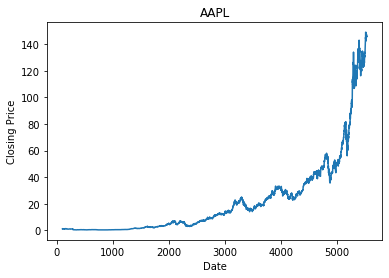

In [10]:
'''
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Support Held")
plt.title(tic)
plt.plot(data_df['floor_held'], 'o')
'''

plt.figure(0)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(tic)
plt.plot(data_df['close'])

In [11]:
#data_df.drop(labels=['date','year', 'dayofyear', 'dayofweek','option_expiry'], axis=1, inplace=True)
data_df_model = data_df[data_df['option_expiry'] != '2999-12-31']
excludeColumns = ['close', 'volume', 'volume_20_sma', 'close_20_ema', 'close_50_ema', 'close_100_ema',
                  'year', 'dayofyear', 'dayofweek','option_expiry']

#date aren't part of training, but are needed in the testing

data_df_train = data_df_model[data_df_model['year'] < 2020]
data_df_train = data_df_train.iloc[:,~data_df_train.columns.isin(excludeColumns)].copy()

data_df_test = data_df_model[data_df_model['year'] >= 2020]
data_df_test = data_df_test.iloc[:,~data_df_test.columns.isin(excludeColumns)].copy()
#data_df_model = data_df_model.iloc[:,~data_df_model.columns.isin(excludeColumns)].copy()

In [12]:
data_df_test

,date,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,close_-1_r,atr,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,floor_held
5131,2020-01-02,0.034328,0.999411,-9.510565e-01,0.309017,2.281632,1.142991,84.583737,-0.145501,-0.062947,-0.112678,-0.172009,1
5132,2020-01-03,0.051479,0.998674,-2.449294e-16,1.000000,-0.972204,1.134206,77.703695,-0.181775,-0.048629,-0.099890,-0.160636,1
5133,2020-01-06,0.102821,0.994700,9.510565e-01,0.309017,0.796825,1.181941,79.183674,0.029867,-0.050802,-0.102809,-0.163959,1
5134,2020-01-07,0.119881,0.992788,5.877853e-01,-0.809017,-0.470305,1.158588,75.953553,0.121160,-0.041906,-0.094704,-0.156840,1
5135,2020-01-08,0.136906,0.990584,-5.877853e-01,-0.809017,1.608629,1.205832,79.081928,-0.074307,-0.051638,-0.104760,-0.166818,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,2021-07-21,-0.329408,-0.944188,-5.877853e-01,-0.809017,-0.513171,2.864887,62.344011,0.157809,-0.025405,-0.064426,-0.092189,1
5522,2021-07-22,-0.345612,-0.938377,-9.510565e-01,0.309017,0.962867,2.860253,64.564400,0.133778,-0.031395,-0.070472,-0.098850,1
5523,2021-07-23,-0.361714,-0.932289,-2.449294e-16,1.000000,1.198906,2.793092,67.184062,0.229173,-0.038787,-0.078289,-0.107357,1
5524,2021-07-26,-0.409356,-0.912375,9.510565e-01,0.309017,0.289451,2.745728,67.810205,0.213568,-0.037603,-0.077775,-0.107756,1


In [13]:
ct = ColumnTransformer([
        ('Standard', StandardScaler(),
         ['close_-1_r', 'atr', 'rsi_14', 'volume_delta', 
          'close_20_ema_delta', 'close_50_ema_delta', 'close_100_ema_delta'])],remainder='passthrough')

XY_train = ct.fit_transform(data_df_train)

X_train,X_val,Y_train,Y_val = train_test_split(XY_train[:, 0:-1],XY_train[:, -1], test_size = 0.2)

X_train2 = np.delete(X_train, -5, axis=1)
X_val2 = np.delete(X_val, -5, axis=1)

In [14]:
XY_test = ct.transform(data_df_test)
X_test = XY_test[:, 0:-1]
Y_test = XY_test[:, -1]
X_test2 = np.delete(X_test, -5, axis=1)
X_test2[0,:]

array([0.8498611573352889, 2.532343609817921, 2.271229728607962,
       -0.6838768749514363, -0.8564737601082214, -0.8578276259653402,
       -0.864528277102914, 0.034327600513243496, 0.9994106342455052,
       -0.9510565162951536, 0.30901699437494723], dtype=object)

In [15]:
X_train2 = X_train2.astype('float32')
X_val2 = X_val2.astype('float32')
X_test2 = X_test2.astype('float32')
Y_train = Y_train.astype('int')
Y_val = Y_val.astype('int')
Y_test = Y_test.astype('int')

In [16]:
def generate_trade_plan(X, Y_pred, Y_actual):
    consecutive_ups = 0
    consecutive_downs = 0
    trades = {}
    err_days = 0
    trade_days = 0
    trade_open = 0

    #inverse transform the stock price
    for i, p in enumerate(Y_pred.tolist()):

        #day = round(np.arccos(X_test[i,-3])*365/(2*np.pi),0)
        #trade_date = datetime(2020, 1, 1) + timedelta(day - 1)
        trade_date = X[i,-5]

        if p[0] == 0:        
            consecutive_ups = 0
            consecutive_downs += 1
        else:
            consecutive_ups += 1
            consecutive_downs = 0
        
        #open the trade
        if consecutive_ups >= 3 and trade_open == 0:
            open_date = trade_date
            trade_open = 1
            err_days = 0
            trade_days = 0
        
        #track errors during trade, exit trade after two consecutive exit signals
        if trade_open == 1:
            
            trade_days += 1
            err_days += (p[0] != Y_actual[i])
            
            if consecutive_downs > 1:
                close_date = trade_date
                trade_open = 0
                trades[(open_date,close_date)] = err_days/trade_days
    
    if trade_open == 1:
        trades[(open_date,)] = err_days/trade_days
        
    return trades

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_constraint=constraints.maxnorm(4)))
    NN.add(layers.Dropout(0.2))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_constraint=constraints.maxnorm(4)))
    NN.add(layers.Dropout(0.2))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Dropout_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 11s - loss: 0.6744 - accuracy: 0.5910 - val_loss: 0.6279 - val_accuracy: 0.6584
Epoch 2/400
126/126 - 0s - loss: 0.6220 - accuracy: 0.6658 - val_loss: 0.6043 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.6010 - accuracy: 0.6938 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6003 - accuracy: 0.7048 - val_loss: 0.5981 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5975 - accuracy: 0.7055 - val_loss: 0.5971 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5941 - accuracy: 0.7065 - val_loss: 0.5963 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7043 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5929 - accuracy: 0.7092 - val_loss: 0.5962 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7095 - val_loss: 0.5951 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7085 - val_loss: 0.5948 - val_accur

Epoch 82/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7130 - val_loss: 0.5827 - val_accuracy: 0.6971
Epoch 83/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7075 - val_loss: 0.5817 - val_accuracy: 0.6971
Epoch 84/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7135 - val_loss: 0.5814 - val_accuracy: 0.6971
Epoch 85/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7140 - val_loss: 0.5813 - val_accuracy: 0.6981
Epoch 86/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7117 - val_loss: 0.5809 - val_accuracy: 0.6961
Epoch 87/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7140 - val_loss: 0.5803 - val_accuracy: 0.6961
Epoch 88/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7117 - val_loss: 0.5807 - val_accuracy: 0.6961
Epoch 89/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7100 - val_loss: 0.5805 - val_accuracy: 0.6961
Epoch 90/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7100 - val_loss: 0.5802 - val_accuracy: 0.6971
Epoch 91/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7120 - val_loss: 0.5801 - v

Epoch 29/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7107 - val_loss: 0.5906 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7073 - val_loss: 0.5909 - val_accuracy: 0.6951
Epoch 31/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7087 - val_loss: 0.5907 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7058 - val_loss: 0.5899 - val_accuracy: 0.6951
Epoch 33/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7105 - val_loss: 0.5895 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7095 - val_loss: 0.5893 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7102 - val_loss: 0.5890 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7070 - val_loss: 0.5889 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7090 - val_loss: 0.5886 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7073 - val_loss: 0.5886 - v

Epoch 110/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7127 - val_loss: 0.5788 - val_accuracy: 0.6941
Epoch 111/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7167 - val_loss: 0.5785 - val_accuracy: 0.6961
Epoch 112/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7120 - val_loss: 0.5778 - val_accuracy: 0.6951
Epoch 113/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7167 - val_loss: 0.5774 - val_accuracy: 0.6981
Epoch 114/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7132 - val_loss: 0.5774 - val_accuracy: 0.6951
Epoch 115/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7092 - val_loss: 0.5770 - val_accuracy: 0.6971
Epoch 116/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7107 - val_loss: 0.5773 - val_accuracy: 0.6951
Epoch 117/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7155 - val_loss: 0.5775 - val_accuracy: 0.6951
Epoch 118/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7145 - val_loss: 0.5780 - val_accuracy: 0.6971
Epoch 119/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7132 - val_loss: 

Epoch 64/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7117 - val_loss: 0.5912 - val_accuracy: 0.6931
Epoch 65/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7115 - val_loss: 0.5911 - val_accuracy: 0.6931
Epoch 66/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7115 - val_loss: 0.5907 - val_accuracy: 0.6931
Epoch 67/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7112 - val_loss: 0.5901 - val_accuracy: 0.6931
Epoch 68/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7092 - val_loss: 0.5903 - val_accuracy: 0.6931
Epoch 69/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7105 - val_loss: 0.5909 - val_accuracy: 0.6931
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
32/32 [==============================] - 0s 791us/step - loss: 0.5900 - accuracy: 0.6941
Epoch 1/400
126/126 - 1s - loss: 0.7211 - accuracy: 0.5497 - val_loss: 0.6423 - val_accuracy: 0.6326
Epoch 2/400
126/126 - 0s - loss: 0.6349 - accuracy: 0.6558 - val_loss: 0.6136 - val_accuracy: 0.6802
Epoch 3/400
1

Epoch 74/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7122 - val_loss: 0.5915 - val_accuracy: 0.6931
Epoch 75/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7102 - val_loss: 0.5911 - val_accuracy: 0.6931
Epoch 76/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7100 - val_loss: 0.5905 - val_accuracy: 0.6931
Epoch 77/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7130 - val_loss: 0.5910 - val_accuracy: 0.6931
Epoch 78/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7125 - val_loss: 0.5906 - val_accuracy: 0.6931
Epoch 79/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7095 - val_loss: 0.5909 - val_accuracy: 0.6931
Epoch 80/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7105 - val_loss: 0.5908 - val_accuracy: 0.6922
Epoch 81/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7115 - val_loss: 0.5903 - val_accuracy: 0.6931
Epoch 82/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7087 - val_loss: 0.5913 - val_accuracy: 0.6922
Epoch 83/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7090 - val_loss: 0.5910 - v

Epoch 154/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7147 - val_loss: 0.5806 - val_accuracy: 0.7001
Epoch 155/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7147 - val_loss: 0.5807 - val_accuracy: 0.6991
Epoch 156/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7147 - val_loss: 0.5814 - val_accuracy: 0.6991
Epoch 157/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7147 - val_loss: 0.5810 - val_accuracy: 0.6991
Epoch 158/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7155 - val_loss: 0.5808 - val_accuracy: 0.7001
Epoch 159/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7137 - val_loss: 0.5807 - val_accuracy: 0.7031
Epoch 160/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7179 - val_loss: 0.5809 - val_accuracy: 0.7001
Epoch 161/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7145 - val_loss: 0.5812 - val_accuracy: 0.6981
Epoch 162/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7132 - val_loss: 0.5810 - val_accuracy: 0.6981
Epoch 163/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7197 - val_loss: 

126/126 - 0s - loss: 0.5853 - accuracy: 0.7097 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7087 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7105 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7078 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7080 - val_loss: 0.5971 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7068 - val_loss: 0.5971 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7100 - val_loss: 0.5966 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7097 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5857 - accuracy: 0.7078 - val_loss: 0.5967 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7097 - val_loss: 0.5970 - val_accuracy: 

Epoch 5/400
126/126 - 0s - loss: 0.6053 - accuracy: 0.7038 - val_loss: 0.5968 - val_accuracy: 0.7011
Epoch 6/400
126/126 - 0s - loss: 0.5974 - accuracy: 0.7038 - val_loss: 0.5962 - val_accuracy: 0.7001
Epoch 7/400
126/126 - 0s - loss: 0.5958 - accuracy: 0.7053 - val_loss: 0.5961 - val_accuracy: 0.7011
Epoch 8/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7068 - val_loss: 0.5955 - val_accuracy: 0.7001
Epoch 9/400
126/126 - 0s - loss: 0.5999 - accuracy: 0.7065 - val_loss: 0.5957 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7073 - val_loss: 0.5959 - val_accuracy: 0.6991
Epoch 11/400
126/126 - 0s - loss: 0.5935 - accuracy: 0.7070 - val_loss: 0.5953 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7097 - val_loss: 0.5951 - val_accuracy: 0.6981
Epoch 13/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7085 - val_loss: 0.5951 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5950 - accuracy: 0.7080 - val_loss: 0.5953 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7130 - val_loss: 0.5868 - val_accuracy: 0.6971
Epoch 87/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7140 - val_loss: 0.5864 - val_accuracy: 0.6951
Epoch 88/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7127 - val_loss: 0.5859 - val_accuracy: 0.6961
Epoch 89/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7152 - val_loss: 0.5861 - val_accuracy: 0.6981
Epoch 90/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7112 - val_loss: 0.5854 - val_accuracy: 0.6961
Epoch 91/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7137 - val_loss: 0.5853 - val_accuracy: 0.6991
Epoch 92/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7135 - val_loss: 0.5852 - val_accuracy: 0.6971
Epoch 93/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7100 - val_loss: 0.5859 - val_accuracy: 0.6971
Epoch 94/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7135 - val_loss: 0.5859 - val_accuracy: 0.6981
Epoch 95/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7117 - val_loss: 0.5859 - v

Epoch 166/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7130 - val_loss: 0.5782 - val_accuracy: 0.7031
Epoch 167/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7157 - val_loss: 0.5777 - val_accuracy: 0.7021
Epoch 168/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7157 - val_loss: 0.5774 - val_accuracy: 0.7011
Epoch 169/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7160 - val_loss: 0.5769 - val_accuracy: 0.7021
Epoch 170/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7189 - val_loss: 0.5774 - val_accuracy: 0.7041
Epoch 171/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7162 - val_loss: 0.5767 - val_accuracy: 0.7061
Epoch 172/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7157 - val_loss: 0.5774 - val_accuracy: 0.7061
Epoch 173/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7167 - val_loss: 0.5770 - val_accuracy: 0.7051
Epoch 174/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7174 - val_loss: 0.5777 - val_accuracy: 0.7021
Epoch 175/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7157 - val_loss: 

Epoch 50/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7120 - val_loss: 0.5892 - val_accuracy: 0.6922
Epoch 51/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7117 - val_loss: 0.5884 - val_accuracy: 0.6922
Epoch 52/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7058 - val_loss: 0.5885 - val_accuracy: 0.6931
Epoch 53/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.5882 - val_accuracy: 0.6922
Epoch 54/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7107 - val_loss: 0.5881 - val_accuracy: 0.6931
Epoch 55/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7090 - val_loss: 0.5878 - val_accuracy: 0.6922
Epoch 56/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7095 - val_loss: 0.5877 - val_accuracy: 0.6931
Epoch 57/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7105 - val_loss: 0.5883 - val_accuracy: 0.6931
Epoch 58/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7120 - val_loss: 0.5877 - val_accuracy: 0.6931
Epoch 59/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7122 - val_loss: 0.5873 - v

Epoch 57/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7073 - val_loss: 0.5917 - val_accuracy: 0.6922
Epoch 58/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7065 - val_loss: 0.5919 - val_accuracy: 0.6931
Epoch 59/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7107 - val_loss: 0.5917 - val_accuracy: 0.6922
Epoch 60/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7095 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 61/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7083 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 62/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7085 - val_loss: 0.5909 - val_accuracy: 0.6922
Epoch 63/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7122 - val_loss: 0.5913 - val_accuracy: 0.6931
Epoch 64/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7068 - val_loss: 0.5914 - val_accuracy: 0.6931
Epoch 65/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7100 - val_loss: 0.5915 - val_accuracy: 0.6922
Epoch 66/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7092 - val_loss: 0.5904 - v

Epoch 137/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7132 - val_loss: 0.5805 - val_accuracy: 0.6951
Epoch 138/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7147 - val_loss: 0.5807 - val_accuracy: 0.6951
Epoch 139/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7130 - val_loss: 0.5807 - val_accuracy: 0.6951
Epoch 140/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7130 - val_loss: 0.5804 - val_accuracy: 0.6961
Epoch 141/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7095 - val_loss: 0.5803 - val_accuracy: 0.6931
Epoch 142/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7132 - val_loss: 0.5800 - val_accuracy: 0.6941
Epoch 143/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7137 - val_loss: 0.5798 - val_accuracy: 0.6951
Epoch 144/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7162 - val_loss: 0.5796 - val_accuracy: 0.6961
Epoch 145/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7127 - val_loss: 0.5796 - val_accuracy: 0.6981
Epoch 146/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7160 - val_loss: 

Epoch 51/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7107 - val_loss: 0.5968 - val_accuracy: 0.6941
Epoch 52/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7102 - val_loss: 0.5968 - val_accuracy: 0.6931
Epoch 53/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7135 - val_loss: 0.5967 - val_accuracy: 0.6961
Epoch 54/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7097 - val_loss: 0.5970 - val_accuracy: 0.6951
Epoch 55/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7107 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 56/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7130 - val_loss: 0.5965 - val_accuracy: 0.6941
Epoch 57/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7110 - val_loss: 0.5964 - val_accuracy: 0.6931
Epoch 58/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7090 - val_loss: 0.5961 - val_accuracy: 0.6931
Epoch 59/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7112 - val_loss: 0.5962 - val_accuracy: 0.6941
Epoch 60/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7092 - val_loss: 0.5964 - v

126/126 - 0s - loss: 0.5754 - accuracy: 0.7135 - val_loss: 0.5867 - val_accuracy: 0.6991
Epoch 132/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7130 - val_loss: 0.5864 - val_accuracy: 0.6991
Epoch 133/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7130 - val_loss: 0.5867 - val_accuracy: 0.7011
Epoch 134/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7117 - val_loss: 0.5871 - val_accuracy: 0.7021
Epoch 135/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7160 - val_loss: 0.5862 - val_accuracy: 0.7021
Epoch 136/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7125 - val_loss: 0.5861 - val_accuracy: 0.7001
Epoch 137/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7140 - val_loss: 0.5856 - val_accuracy: 0.7021
Epoch 138/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7130 - val_loss: 0.5859 - val_accuracy: 0.7021
Epoch 139/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7162 - val_loss: 0.5858 - val_accuracy: 0.7001
Epoch 140/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7127 - val_loss: 0.5853 - val_a

Epoch 211/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7120 - val_loss: 0.5805 - val_accuracy: 0.7031
Epoch 212/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7127 - val_loss: 0.5802 - val_accuracy: 0.7041
Epoch 213/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7155 - val_loss: 0.5801 - val_accuracy: 0.7051
Epoch 214/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7145 - val_loss: 0.5800 - val_accuracy: 0.7080
Epoch 215/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7160 - val_loss: 0.5795 - val_accuracy: 0.7071
Epoch 216/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7145 - val_loss: 0.5796 - val_accuracy: 0.7080
Epoch 217/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7160 - val_loss: 0.5798 - val_accuracy: 0.7080
Epoch 218/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7167 - val_loss: 0.5797 - val_accuracy: 0.7061
Epoch 219/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7157 - val_loss: 0.5795 - val_accuracy: 0.7051
Epoch 220/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7120 - val_loss: 

126/126 - 0s - loss: 0.5864 - accuracy: 0.7063 - val_loss: 0.5973 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7068 - val_loss: 0.5971 - val_accuracy: 0.6922
Epoch 21/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7110 - val_loss: 0.5962 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7112 - val_loss: 0.5970 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7075 - val_loss: 0.5965 - val_accuracy: 0.6922
Epoch 24/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7068 - val_loss: 0.5963 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7078 - val_loss: 0.5958 - val_accuracy: 0.6922
Epoch 26/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7110 - val_loss: 0.5959 - val_accuracy: 0.6922
Epoch 27/400
126/126 - 0s - loss: 0.5863 - accuracy: 0.7095 - val_loss: 0.5953 - val_accuracy: 0.6922
Epoch 28/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7102 - val_loss: 0.5953 - val_accuracy: 

Epoch 29/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7125 - val_loss: 0.5969 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7107 - val_loss: 0.5971 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7125 - val_loss: 0.5964 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7122 - val_loss: 0.5960 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7122 - val_loss: 0.5956 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7115 - val_loss: 0.5953 - val_accuracy: 0.6941
Epoch 35/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7105 - val_loss: 0.5954 - val_accuracy: 0.6941
Epoch 36/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7115 - val_loss: 0.5955 - val_accuracy: 0.6931
Epoch 37/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7107 - val_loss: 0.5952 - val_accuracy: 0.6931
Epoch 38/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7135 - val_loss: 0.5956 - v

Epoch 110/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7127 - val_loss: 0.5840 - val_accuracy: 0.6941
Epoch 111/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7167 - val_loss: 0.5835 - val_accuracy: 0.6951
Epoch 112/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7140 - val_loss: 0.5840 - val_accuracy: 0.6951
Epoch 113/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7165 - val_loss: 0.5835 - val_accuracy: 0.6941
Epoch 114/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7167 - val_loss: 0.5834 - val_accuracy: 0.6941
Epoch 115/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7145 - val_loss: 0.5835 - val_accuracy: 0.6951
Epoch 116/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7192 - val_loss: 0.5835 - val_accuracy: 0.6961
Epoch 117/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7117 - val_loss: 0.5833 - val_accuracy: 0.6951
Epoch 118/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7169 - val_loss: 0.5832 - val_accuracy: 0.6951
Epoch 119/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7120 - val_loss: 

Epoch 22/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7085 - val_loss: 0.5975 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7097 - val_loss: 0.5968 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7053 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 25/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7110 - val_loss: 0.5961 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7112 - val_loss: 0.5960 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7122 - val_loss: 0.5956 - val_accuracy: 0.6951
Epoch 28/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7083 - val_loss: 0.5961 - val_accuracy: 0.6951
Epoch 29/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7073 - val_loss: 0.5961 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7110 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 31/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7068 - val_loss: 0.5956 - v

Epoch 103/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7107 - val_loss: 0.5826 - val_accuracy: 0.6931
Epoch 104/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7117 - val_loss: 0.5822 - val_accuracy: 0.6941
Epoch 105/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7122 - val_loss: 0.5827 - val_accuracy: 0.6941
Epoch 106/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7157 - val_loss: 0.5821 - val_accuracy: 0.6941
Epoch 107/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7122 - val_loss: 0.5819 - val_accuracy: 0.6941
Epoch 108/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7105 - val_loss: 0.5815 - val_accuracy: 0.6941
Epoch 109/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7100 - val_loss: 0.5820 - val_accuracy: 0.6931
Epoch 110/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7107 - val_loss: 0.5818 - val_accuracy: 0.6931
Epoch 111/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7125 - val_loss: 0.5813 - val_accuracy: 0.6941
Epoch 112/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7117 - val_loss: 

126/126 - 0s - loss: 0.5926 - accuracy: 0.7075 - val_loss: 0.5986 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7100 - val_loss: 0.5984 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7083 - val_loss: 0.5985 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7115 - val_loss: 0.5979 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7105 - val_loss: 0.5979 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7107 - val_loss: 0.5979 - val_accuracy: 0.6981
Epoch 20/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7125 - val_loss: 0.5975 - val_accuracy: 0.7001
Epoch 21/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7095 - val_loss: 0.5972 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7095 - val_loss: 0.5979 - val_accuracy: 0.6991
Epoch 23/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7095 - val_loss: 0.5976 - val_accuracy: 

Epoch 95/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7115 - val_loss: 0.5875 - val_accuracy: 0.6931
Epoch 96/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7070 - val_loss: 0.5871 - val_accuracy: 0.6922
Epoch 97/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7097 - val_loss: 0.5863 - val_accuracy: 0.6931
Epoch 98/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7142 - val_loss: 0.5863 - val_accuracy: 0.6931
Epoch 99/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7135 - val_loss: 0.5864 - val_accuracy: 0.6931
Epoch 100/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7075 - val_loss: 0.5868 - val_accuracy: 0.6922
Epoch 101/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7112 - val_loss: 0.5862 - val_accuracy: 0.6931
Epoch 102/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7112 - val_loss: 0.5862 - val_accuracy: 0.6931
Epoch 103/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7100 - val_loss: 0.5859 - val_accuracy: 0.6931
Epoch 104/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7122 - val_loss: 0.585

Epoch 35/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7097 - val_loss: 0.5956 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7117 - val_loss: 0.5955 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7078 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7107 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7100 - val_loss: 0.5942 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7110 - val_loss: 0.5935 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7107 - val_loss: 0.5934 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7085 - val_loss: 0.5934 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7097 - val_loss: 0.5930 - val_accuracy: 0.6951
Epoch 44/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7132 - val_loss: 0.5926 - v

Epoch 42/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7110 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7097 - val_loss: 0.5876 - val_accuracy: 0.6951
Epoch 44/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7130 - val_loss: 0.5870 - val_accuracy: 0.6951
Epoch 45/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7130 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 46/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7130 - val_loss: 0.5871 - val_accuracy: 0.6951
Epoch 47/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7127 - val_loss: 0.5870 - val_accuracy: 0.6951
Epoch 48/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7092 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 49/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7122 - val_loss: 0.5865 - val_accuracy: 0.6951
Epoch 50/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7083 - val_loss: 0.5863 - val_accuracy: 0.6951
Epoch 51/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7092 - val_loss: 0.5861 - v

126/126 - 0s - loss: 0.5756 - accuracy: 0.7142 - val_loss: 0.5762 - val_accuracy: 0.7031
Epoch 123/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7135 - val_loss: 0.5765 - val_accuracy: 0.7021
Epoch 124/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7155 - val_loss: 0.5773 - val_accuracy: 0.7021
Epoch 125/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7187 - val_loss: 0.5769 - val_accuracy: 0.7041
Epoch 126/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7155 - val_loss: 0.5768 - val_accuracy: 0.7061
Epoch 127/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7207 - val_loss: 0.5766 - val_accuracy: 0.7041
Epoch 128/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7165 - val_loss: 0.5767 - val_accuracy: 0.7051
Epoch 129/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7177 - val_loss: 0.5760 - val_accuracy: 0.7061
Epoch 130/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7189 - val_loss: 0.5764 - val_accuracy: 0.7071
Epoch 131/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7165 - val_loss: 0.5758 - val_a

Epoch 33/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7115 - val_loss: 0.5890 - val_accuracy: 0.6922
Epoch 34/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7085 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7107 - val_loss: 0.5891 - val_accuracy: 0.6931
Epoch 36/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7100 - val_loss: 0.5894 - val_accuracy: 0.6931
Epoch 37/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7127 - val_loss: 0.5890 - val_accuracy: 0.6922
Epoch 38/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7105 - val_loss: 0.5891 - val_accuracy: 0.6931
Epoch 39/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7095 - val_loss: 0.5884 - val_accuracy: 0.6922
Epoch 40/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7125 - val_loss: 0.5882 - val_accuracy: 0.6922
Epoch 41/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7090 - val_loss: 0.5882 - val_accuracy: 0.6922
Epoch 42/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7080 - val_loss: 0.5881 - v

Epoch 114/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7135 - val_loss: 0.5767 - val_accuracy: 0.6971
Epoch 115/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7127 - val_loss: 0.5767 - val_accuracy: 0.6971
Epoch 116/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7102 - val_loss: 0.5765 - val_accuracy: 0.6971
Epoch 117/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7100 - val_loss: 0.5769 - val_accuracy: 0.6971
Epoch 118/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7097 - val_loss: 0.5767 - val_accuracy: 0.6971
Epoch 119/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7122 - val_loss: 0.5759 - val_accuracy: 0.6971
Epoch 120/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7115 - val_loss: 0.5760 - val_accuracy: 0.6971
Epoch 121/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7165 - val_loss: 0.5762 - val_accuracy: 0.6971
Epoch 122/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7127 - val_loss: 0.5760 - val_accuracy: 0.6981
Epoch 123/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7140 - val_loss: 

Epoch 64/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7073 - val_loss: 0.5902 - val_accuracy: 0.6931
Epoch 65/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7090 - val_loss: 0.5902 - val_accuracy: 0.6941
Epoch 66/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7127 - val_loss: 0.5898 - val_accuracy: 0.6941
Epoch 67/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7110 - val_loss: 0.5898 - val_accuracy: 0.6941
Epoch 68/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7112 - val_loss: 0.5895 - val_accuracy: 0.6931
Epoch 69/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7102 - val_loss: 0.5900 - val_accuracy: 0.6931
Epoch 70/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7095 - val_loss: 0.5894 - val_accuracy: 0.6931
Epoch 71/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7090 - val_loss: 0.5895 - val_accuracy: 0.6931
Epoch 72/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7085 - val_loss: 0.5892 - val_accuracy: 0.6931
Epoch 73/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7145 - val_loss: 0.5889 - v

Epoch 4/400
126/126 - 0s - loss: 0.6167 - accuracy: 0.6946 - val_loss: 0.6072 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.6054 - accuracy: 0.6943 - val_loss: 0.6048 - val_accuracy: 0.6922
Epoch 6/400
126/126 - 0s - loss: 0.6100 - accuracy: 0.7043 - val_loss: 0.6035 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.6069 - accuracy: 0.6983 - val_loss: 0.6028 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6014 - accuracy: 0.7020 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5968 - accuracy: 0.7040 - val_loss: 0.6004 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5950 - accuracy: 0.7075 - val_loss: 0.5996 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5983 - accuracy: 0.7040 - val_loss: 0.5990 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5983 - accuracy: 0.7065 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5933 - accuracy: 0.7033 - val_loss: 0.5984 - val_acc

Epoch 85/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7115 - val_loss: 0.5857 - val_accuracy: 0.6931
Epoch 86/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7140 - val_loss: 0.5860 - val_accuracy: 0.6931
Epoch 87/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7117 - val_loss: 0.5852 - val_accuracy: 0.6941
Epoch 88/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7117 - val_loss: 0.5854 - val_accuracy: 0.6941
Epoch 89/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7110 - val_loss: 0.5851 - val_accuracy: 0.6931
Epoch 90/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7107 - val_loss: 0.5849 - val_accuracy: 0.6961
Epoch 91/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7132 - val_loss: 0.5849 - val_accuracy: 0.6931
Epoch 92/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7117 - val_loss: 0.5847 - val_accuracy: 0.6922
Epoch 93/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7125 - val_loss: 0.5851 - val_accuracy: 0.6931
Epoch 94/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7132 - val_loss: 0.5850 - v

Epoch 165/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7150 - val_loss: 0.5749 - val_accuracy: 0.7051
Epoch 166/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7110 - val_loss: 0.5749 - val_accuracy: 0.7061
Epoch 167/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7165 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 168/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7162 - val_loss: 0.5742 - val_accuracy: 0.7011
Epoch 169/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7145 - val_loss: 0.5743 - val_accuracy: 0.7051
Epoch 170/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7187 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 171/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7135 - val_loss: 0.5738 - val_accuracy: 0.7100
Epoch 172/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7155 - val_loss: 0.5738 - val_accuracy: 0.7090
Epoch 173/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7165 - val_loss: 0.5734 - val_accuracy: 0.7080
Epoch 174/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7157 - val_loss: 

Epoch 31/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7112 - val_loss: 0.5927 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7120 - val_loss: 0.5922 - val_accuracy: 0.6922
Epoch 33/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7102 - val_loss: 0.5915 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7073 - val_loss: 0.5915 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7080 - val_loss: 0.5914 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7063 - val_loss: 0.5915 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7085 - val_loss: 0.5907 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7090 - val_loss: 0.5903 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7120 - val_loss: 0.5895 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7105 - val_loss: 0.5891 - v

Epoch 112/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7120 - val_loss: 0.5770 - val_accuracy: 0.6981
Epoch 113/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7117 - val_loss: 0.5773 - val_accuracy: 0.6991
Epoch 114/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7135 - val_loss: 0.5773 - val_accuracy: 0.6981
Epoch 115/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7085 - val_loss: 0.5774 - val_accuracy: 0.6991
Epoch 116/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7150 - val_loss: 0.5772 - val_accuracy: 0.6981
Epoch 117/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7174 - val_loss: 0.5770 - val_accuracy: 0.6981
Epoch 118/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7097 - val_loss: 0.5777 - val_accuracy: 0.6981
Epoch 119/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7085 - val_loss: 0.5765 - val_accuracy: 0.7001
Epoch 120/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7095 - val_loss: 0.5767 - val_accuracy: 0.6981
Epoch 121/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7078 - val_loss: 

Epoch 62/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7135 - val_loss: 0.5879 - val_accuracy: 0.6922
Epoch 63/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7125 - val_loss: 0.5885 - val_accuracy: 0.6931
Epoch 64/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7152 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 65/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7122 - val_loss: 0.5882 - val_accuracy: 0.6951
Epoch 66/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7147 - val_loss: 0.5882 - val_accuracy: 0.6931
Epoch 67/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7112 - val_loss: 0.5877 - val_accuracy: 0.6961
Epoch 68/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7097 - val_loss: 0.5875 - val_accuracy: 0.6931
Epoch 69/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7115 - val_loss: 0.5877 - val_accuracy: 0.6931
Epoch 70/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7095 - val_loss: 0.5878 - val_accuracy: 0.6951
Epoch 71/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7132 - val_loss: 0.5873 - v

Epoch 45/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7097 - val_loss: 0.5947 - val_accuracy: 0.6931
Epoch 46/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7092 - val_loss: 0.5949 - val_accuracy: 0.6931
Epoch 47/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7085 - val_loss: 0.5951 - val_accuracy: 0.6931
Epoch 48/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7045 - val_loss: 0.5952 - val_accuracy: 0.6931
Epoch 49/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7068 - val_loss: 0.5942 - val_accuracy: 0.6931
Epoch 50/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7122 - val_loss: 0.5936 - val_accuracy: 0.6931
Epoch 51/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7135 - val_loss: 0.5930 - val_accuracy: 0.6931
Epoch 52/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7078 - val_loss: 0.5928 - val_accuracy: 0.6931
Epoch 53/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7105 - val_loss: 0.5924 - val_accuracy: 0.6931
Epoch 54/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7097 - val_loss: 0.5925 - v

Epoch 9/400
126/126 - 0s - loss: 0.5903 - accuracy: 0.7105 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.5904 - accuracy: 0.7097 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7112 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7110 - val_loss: 0.5962 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7097 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7083 - val_loss: 0.5956 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7092 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7078 - val_loss: 0.5951 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7092 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5880 - accuracy: 0.7055 - val_loss: 0.5945 - va

Epoch 90/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7165 - val_loss: 0.5805 - val_accuracy: 0.7011
Epoch 91/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7130 - val_loss: 0.5803 - val_accuracy: 0.6981
Epoch 92/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7125 - val_loss: 0.5808 - val_accuracy: 0.6971
Epoch 93/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7167 - val_loss: 0.5807 - val_accuracy: 0.6991
Epoch 94/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7130 - val_loss: 0.5805 - val_accuracy: 0.7001
Epoch 95/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7172 - val_loss: 0.5806 - val_accuracy: 0.7021
Epoch 96/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7125 - val_loss: 0.5800 - val_accuracy: 0.7001
Epoch 97/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7140 - val_loss: 0.5800 - val_accuracy: 0.7031
Epoch 98/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7145 - val_loss: 0.5804 - val_accuracy: 0.7011
Epoch 99/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7092 - val_loss: 0.5807 - v

Epoch 38/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7112 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7105 - val_loss: 0.5870 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7135 - val_loss: 0.5866 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7107 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7100 - val_loss: 0.5871 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7117 - val_loss: 0.5875 - val_accuracy: 0.6951
Epoch 44/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7122 - val_loss: 0.5866 - val_accuracy: 0.6951
Epoch 45/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7107 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 46/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7063 - val_loss: 0.5865 - val_accuracy: 0.6951
Epoch 47/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7135 - val_loss: 0.5862 - v

Epoch 119/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7127 - val_loss: 0.5779 - val_accuracy: 0.6991
Epoch 120/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7125 - val_loss: 0.5776 - val_accuracy: 0.7051
Epoch 121/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7145 - val_loss: 0.5771 - val_accuracy: 0.7011
Epoch 122/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7087 - val_loss: 0.5774 - val_accuracy: 0.7011
Epoch 123/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7145 - val_loss: 0.5772 - val_accuracy: 0.7021
Epoch 124/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7122 - val_loss: 0.5772 - val_accuracy: 0.7021
Epoch 125/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7132 - val_loss: 0.5769 - val_accuracy: 0.7051
Epoch 126/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7150 - val_loss: 0.5761 - val_accuracy: 0.7080
Epoch 127/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7142 - val_loss: 0.5762 - val_accuracy: 0.7080
Epoch 128/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7160 - val_loss: 

Epoch 25/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7117 - val_loss: 0.5942 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7117 - val_loss: 0.5945 - val_accuracy: 0.6971
Epoch 27/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7100 - val_loss: 0.5942 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7078 - val_loss: 0.5942 - val_accuracy: 0.6971
Epoch 29/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7135 - val_loss: 0.5940 - val_accuracy: 0.6961
Epoch 30/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7115 - val_loss: 0.5943 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7102 - val_loss: 0.5942 - val_accuracy: 0.6961
Epoch 32/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7097 - val_loss: 0.5941 - val_accuracy: 0.6961
Epoch 33/400
126/126 - 0s - loss: 0.5857 - accuracy: 0.7092 - val_loss: 0.5941 - val_accuracy: 0.6961
Epoch 34/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7102 - val_loss: 0.5938 - v

Epoch 32/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7097 - val_loss: 0.5975 - val_accuracy: 0.6931
Epoch 33/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7105 - val_loss: 0.5971 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7070 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 35/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7100 - val_loss: 0.5969 - val_accuracy: 0.6931
Epoch 36/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7092 - val_loss: 0.5970 - val_accuracy: 0.6931
Epoch 37/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7110 - val_loss: 0.5959 - val_accuracy: 0.6941
Epoch 38/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7122 - val_loss: 0.5963 - val_accuracy: 0.6941
Epoch 39/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7090 - val_loss: 0.5954 - val_accuracy: 0.6941
Epoch 40/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7117 - val_loss: 0.5948 - val_accuracy: 0.6941
Epoch 41/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7085 - val_loss: 0.5954 - v

Epoch 113/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7157 - val_loss: 0.5777 - val_accuracy: 0.6971
Epoch 114/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7130 - val_loss: 0.5774 - val_accuracy: 0.7001
Epoch 115/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7162 - val_loss: 0.5772 - val_accuracy: 0.6981
Epoch 116/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7110 - val_loss: 0.5771 - val_accuracy: 0.7001
Epoch 117/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7125 - val_loss: 0.5776 - val_accuracy: 0.6991
Epoch 118/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7112 - val_loss: 0.5779 - val_accuracy: 0.7011
Epoch 119/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7165 - val_loss: 0.5770 - val_accuracy: 0.6981
Epoch 120/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7172 - val_loss: 0.5768 - val_accuracy: 0.6981
Epoch 121/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7165 - val_loss: 0.5771 - val_accuracy: 0.6991
Epoch 122/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7150 - val_loss: 

Epoch 42/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7058 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 43/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7152 - val_loss: 0.5930 - val_accuracy: 0.6922
Epoch 44/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7110 - val_loss: 0.5926 - val_accuracy: 0.6941
Epoch 45/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7107 - val_loss: 0.5923 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7122 - val_loss: 0.5922 - val_accuracy: 0.6931
Epoch 47/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7132 - val_loss: 0.5924 - val_accuracy: 0.6931
Epoch 48/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7100 - val_loss: 0.5921 - val_accuracy: 0.6941
Epoch 49/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7135 - val_loss: 0.5917 - val_accuracy: 0.6941
Epoch 50/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7117 - val_loss: 0.5915 - val_accuracy: 0.6941
Epoch 51/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7117 - val_loss: 0.5916 - v

126/126 - 0s - loss: 0.5780 - accuracy: 0.7120 - val_loss: 0.5868 - val_accuracy: 0.6931
Epoch 123/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7135 - val_loss: 0.5868 - val_accuracy: 0.6931
Epoch 124/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7137 - val_loss: 0.5867 - val_accuracy: 0.6951
Epoch 125/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7140 - val_loss: 0.5865 - val_accuracy: 0.6941
Epoch 126/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7140 - val_loss: 0.5862 - val_accuracy: 0.6941
Epoch 127/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7105 - val_loss: 0.5864 - val_accuracy: 0.6941
Epoch 128/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7147 - val_loss: 0.5864 - val_accuracy: 0.6941
Epoch 129/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7135 - val_loss: 0.5862 - val_accuracy: 0.6951
Epoch 130/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7140 - val_loss: 0.5865 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
32/

Epoch 71/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7105 - val_loss: 0.5886 - val_accuracy: 0.6931
Epoch 72/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7100 - val_loss: 0.5883 - val_accuracy: 0.6931
Epoch 73/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7102 - val_loss: 0.5884 - val_accuracy: 0.6931
Epoch 74/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7145 - val_loss: 0.5888 - val_accuracy: 0.6931
Epoch 75/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7115 - val_loss: 0.5880 - val_accuracy: 0.6922
Epoch 76/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7137 - val_loss: 0.5874 - val_accuracy: 0.6931
Epoch 77/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7122 - val_loss: 0.5878 - val_accuracy: 0.6931
Epoch 78/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7107 - val_loss: 0.5876 - val_accuracy: 0.6931
Epoch 79/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7135 - val_loss: 0.5880 - val_accuracy: 0.6931
Epoch 80/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7117 - val_loss: 0.5875 - v

Epoch 151/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7127 - val_loss: 0.5791 - val_accuracy: 0.6951
Epoch 152/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7187 - val_loss: 0.5786 - val_accuracy: 0.6951
Epoch 153/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7174 - val_loss: 0.5781 - val_accuracy: 0.6951
Epoch 154/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7152 - val_loss: 0.5777 - val_accuracy: 0.6931
Epoch 155/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7172 - val_loss: 0.5779 - val_accuracy: 0.6951
Epoch 156/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7132 - val_loss: 0.5783 - val_accuracy: 0.6951
Epoch 157/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7147 - val_loss: 0.5777 - val_accuracy: 0.6951
Epoch 158/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7145 - val_loss: 0.5772 - val_accuracy: 0.6941
Epoch 159/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7130 - val_loss: 0.5773 - val_accuracy: 0.6951
Epoch 160/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7155 - val_loss: 

Epoch 51/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7115 - val_loss: 0.5911 - val_accuracy: 0.6922
Epoch 52/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7125 - val_loss: 0.5908 - val_accuracy: 0.6922
Epoch 53/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7132 - val_loss: 0.5902 - val_accuracy: 0.6922
Epoch 54/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7078 - val_loss: 0.5905 - val_accuracy: 0.6931
Epoch 55/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7095 - val_loss: 0.5905 - val_accuracy: 0.6941
Epoch 56/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7107 - val_loss: 0.5902 - val_accuracy: 0.6931
Epoch 57/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7115 - val_loss: 0.5902 - val_accuracy: 0.6931
Epoch 58/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7120 - val_loss: 0.5903 - val_accuracy: 0.6951
Epoch 59/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7130 - val_loss: 0.5898 - val_accuracy: 0.6951
Epoch 60/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7125 - val_loss: 0.5898 - v

In [18]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Dropout_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Drop1_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Drop1_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 708us/step - loss: 0.5707 - accuracy: 0.7160
Test Loss: 0.571
Test Accuracy: 0.716


In [19]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

C:\Users\btang\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{('2020-01-06',): 0.25699745547073793}

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(10, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_constraint=constraints.maxnorm(4)))
    NN.add(layers.Dropout(0.2))
    NN.add(layers.Dense(8, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_constraint=constraints.maxnorm(4)))
    NN.add(layers.Dropout(0.2))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Dropout_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 2s - loss: 0.6806 - accuracy: 0.5880 - val_loss: 0.6351 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.6207 - accuracy: 0.6836 - val_loss: 0.6101 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.6022 - accuracy: 0.7048 - val_loss: 0.6043 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6025 - accuracy: 0.7065 - val_loss: 0.6031 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5964 - accuracy: 0.7040 - val_loss: 0.6013 - val_accuracy: 0.6922
Epoch 6/400
126/126 - 0s - loss: 0.5951 - accuracy: 0.7073 - val_loss: 0.6000 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.5945 - accuracy: 0.7055 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7097 - val_loss: 0.5992 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5934 - accuracy: 0.7087 - val_loss: 0.5980 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7053 - val_loss: 0.5975 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7105 - val_loss: 0.5797 - val_accuracy: 0.6971
Epoch 83/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7085 - val_loss: 0.5788 - val_accuracy: 0.6951
Epoch 84/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7137 - val_loss: 0.5786 - val_accuracy: 0.6971
Epoch 85/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7140 - val_loss: 0.5781 - val_accuracy: 0.6961
Epoch 86/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7127 - val_loss: 0.5781 - val_accuracy: 0.6981
Epoch 87/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7127 - val_loss: 0.5776 - val_accuracy: 0.6971
Epoch 88/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7105 - val_loss: 0.5780 - val_accuracy: 0.6961
Epoch 89/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7125 - val_loss: 0.5779 - val_accuracy: 0.6961
Epoch 90/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7127 - val_loss: 0.5773 - val_accuracy: 0.6951
Epoch 91/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7127 - val_loss: 0.5768 - v

Epoch 16/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7110 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7105 - val_loss: 0.5978 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7083 - val_loss: 0.5973 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7102 - val_loss: 0.5976 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7073 - val_loss: 0.5974 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7090 - val_loss: 0.5970 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7092 - val_loss: 0.5978 - val_accuracy: 0.6941
Epoch 23/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7112 - val_loss: 0.5961 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7087 - val_loss: 0.5957 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7107 - val_loss: 0.5959 - v

Epoch 97/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7112 - val_loss: 0.5813 - val_accuracy: 0.6941
Epoch 98/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7172 - val_loss: 0.5812 - val_accuracy: 0.6941
Epoch 99/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7092 - val_loss: 0.5813 - val_accuracy: 0.6951
Epoch 100/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7122 - val_loss: 0.5813 - val_accuracy: 0.6922
Epoch 101/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7122 - val_loss: 0.5813 - val_accuracy: 0.6931
Epoch 102/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7120 - val_loss: 0.5809 - val_accuracy: 0.6931
Epoch 103/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7137 - val_loss: 0.5810 - val_accuracy: 0.6931
Epoch 104/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7110 - val_loss: 0.5808 - val_accuracy: 0.6961
Epoch 105/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7137 - val_loss: 0.5805 - val_accuracy: 0.6941
Epoch 106/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7142 - val_loss: 0.5

126/126 - 0s - loss: 0.5905 - accuracy: 0.7107 - val_loss: 0.5987 - val_accuracy: 0.6902
Epoch 10/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7100 - val_loss: 0.5985 - val_accuracy: 0.6912
Epoch 11/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7132 - val_loss: 0.5984 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7083 - val_loss: 0.5981 - val_accuracy: 0.6922
Epoch 13/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7127 - val_loss: 0.5978 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7092 - val_loss: 0.5979 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7107 - val_loss: 0.5984 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7087 - val_loss: 0.5983 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5863 - accuracy: 0.7095 - val_loss: 0.5976 - val_accuracy: 0.6922
Epoch 18/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7117 - val_loss: 0.5971 - val_accuracy: 

Epoch 90/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7120 - val_loss: 0.5900 - val_accuracy: 0.6941
Epoch 91/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7097 - val_loss: 0.5904 - val_accuracy: 0.6931
Epoch 92/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7125 - val_loss: 0.5901 - val_accuracy: 0.6941
Epoch 93/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7155 - val_loss: 0.5904 - val_accuracy: 0.6941
Epoch 94/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.6941
Epoch 95/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7192 - val_loss: 0.5898 - val_accuracy: 0.6941
Epoch 96/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7140 - val_loss: 0.5894 - val_accuracy: 0.6931
Epoch 97/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7152 - val_loss: 0.5898 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
32/32 [==============================] - 0s 869us/step - loss: 0.5893 - accuracy: 0.6941
Epoch 1/400

Epoch 72/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7169 - val_loss: 0.5909 - val_accuracy: 0.6922
Epoch 73/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7107 - val_loss: 0.5907 - val_accuracy: 0.6912
Epoch 74/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7105 - val_loss: 0.5905 - val_accuracy: 0.6912
Epoch 75/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7142 - val_loss: 0.5900 - val_accuracy: 0.6922
Epoch 76/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7107 - val_loss: 0.5897 - val_accuracy: 0.6912
Epoch 77/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7090 - val_loss: 0.5896 - val_accuracy: 0.6912
Epoch 78/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7162 - val_loss: 0.5900 - val_accuracy: 0.6902
Epoch 79/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7160 - val_loss: 0.5902 - val_accuracy: 0.6892
Epoch 80/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7087 - val_loss: 0.5896 - val_accuracy: 0.6892
Epoch 81/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7080 - val_loss: 0.5891 - v

Epoch 152/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7169 - val_loss: 0.5802 - val_accuracy: 0.7021
Epoch 153/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7204 - val_loss: 0.5800 - val_accuracy: 0.7071
Epoch 154/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7199 - val_loss: 0.5794 - val_accuracy: 0.7051
Epoch 155/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7132 - val_loss: 0.5799 - val_accuracy: 0.7001
Epoch 156/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7187 - val_loss: 0.5800 - val_accuracy: 0.6991
Epoch 157/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7177 - val_loss: 0.5794 - val_accuracy: 0.7041
Epoch 158/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7172 - val_loss: 0.5792 - val_accuracy: 0.7061
Epoch 159/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7107 - val_loss: 0.5790 - val_accuracy: 0.7061
Epoch 160/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7197 - val_loss: 0.5796 - val_accuracy: 0.7021
Epoch 161/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7179 - val_loss: 

Epoch 2/400
126/126 - 0s - loss: 0.6193 - accuracy: 0.6623 - val_loss: 0.6084 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6008 - accuracy: 0.6951 - val_loss: 0.6033 - val_accuracy: 0.6941
Epoch 4/400
126/126 - 0s - loss: 0.5941 - accuracy: 0.7010 - val_loss: 0.6031 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7087 - val_loss: 0.6025 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.5913 - accuracy: 0.7053 - val_loss: 0.6012 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5927 - accuracy: 0.7040 - val_loss: 0.6005 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7063 - val_loss: 0.6004 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5940 - accuracy: 0.7030 - val_loss: 0.6001 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7100 - val_loss: 0.5993 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7075 - val_loss: 0.5981 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7140 - val_loss: 0.5801 - val_accuracy: 0.6981
Epoch 84/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7122 - val_loss: 0.5801 - val_accuracy: 0.6981
Epoch 85/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7172 - val_loss: 0.5797 - val_accuracy: 0.6961
Epoch 86/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7125 - val_loss: 0.5799 - val_accuracy: 0.6981
Epoch 87/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7137 - val_loss: 0.5784 - val_accuracy: 0.6981
Epoch 88/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7132 - val_loss: 0.5793 - val_accuracy: 0.6991
Epoch 89/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7135 - val_loss: 0.5792 - val_accuracy: 0.6991
Epoch 90/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7137 - val_loss: 0.5787 - val_accuracy: 0.7001
Epoch 91/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7140 - val_loss: 0.5791 - val_accuracy: 0.7001
Epoch 92/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7117 - val_loss: 0.5789 - v

Epoch 38/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7115 - val_loss: 0.5904 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7120 - val_loss: 0.5899 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7068 - val_loss: 0.5893 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7065 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7078 - val_loss: 0.5889 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7083 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 44/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7095 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 45/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7122 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 46/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7065 - val_loss: 0.5883 - val_accuracy: 0.6951
Epoch 47/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7095 - val_loss: 0.5880 - v

Epoch 119/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7132 - val_loss: 0.5749 - val_accuracy: 0.7001
Epoch 120/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7150 - val_loss: 0.5745 - val_accuracy: 0.7001
Epoch 121/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7095 - val_loss: 0.5745 - val_accuracy: 0.6981
Epoch 122/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7090 - val_loss: 0.5743 - val_accuracy: 0.7011
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
32/32 [==============================] - 0s 676us/step - loss: 0.5737 - accuracy: 0.6981
Epoch 1/400
126/126 - 1s - loss: 0.7438 - accuracy: 0.5678 - val_loss: 0.6314 - val_accuracy: 0.6485
Epoch 2/400
126/126 - 0s - loss: 0.6414 - accuracy: 0.6605 - val_loss: 0.6089 - val_accuracy: 0.6792
Epoch 3/400
126/126 - 0s - loss: 0.6217 - accuracy: 0.6792 - val_loss: 0.6054 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.6069 - accuracy: 0.6948 - val_loss: 0.6039 - val_accuracy: 0.6971
Epoch 5/400

Epoch 76/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7125 - val_loss: 0.5848 - val_accuracy: 0.6941
Epoch 77/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7120 - val_loss: 0.5857 - val_accuracy: 0.6941
Epoch 78/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7127 - val_loss: 0.5853 - val_accuracy: 0.6931
Epoch 79/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7087 - val_loss: 0.5859 - val_accuracy: 0.6941
Epoch 80/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7070 - val_loss: 0.5852 - val_accuracy: 0.6931
Epoch 81/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7150 - val_loss: 0.5845 - val_accuracy: 0.6922
Epoch 82/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7122 - val_loss: 0.5856 - val_accuracy: 0.6951
Epoch 83/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7132 - val_loss: 0.5848 - val_accuracy: 0.6931
Epoch 84/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7135 - val_loss: 0.5847 - val_accuracy: 0.6931
Epoch 85/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7135 - val_loss: 0.5846 - v

Epoch 14/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7083 - val_loss: 0.5952 - val_accuracy: 0.7001
Epoch 15/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7100 - val_loss: 0.5949 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5906 - accuracy: 0.7127 - val_loss: 0.5953 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5880 - accuracy: 0.7100 - val_loss: 0.5941 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5878 - accuracy: 0.7112 - val_loss: 0.5933 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7110 - val_loss: 0.5933 - val_accuracy: 0.7001
Epoch 20/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7130 - val_loss: 0.5928 - val_accuracy: 0.6991
Epoch 21/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7085 - val_loss: 0.5924 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7137 - val_loss: 0.5931 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7125 - val_loss: 0.5922 - v

Epoch 95/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7125 - val_loss: 0.5802 - val_accuracy: 0.6941
Epoch 96/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7125 - val_loss: 0.5794 - val_accuracy: 0.6981
Epoch 97/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7125 - val_loss: 0.5788 - val_accuracy: 0.6941
Epoch 98/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7105 - val_loss: 0.5784 - val_accuracy: 0.6981
Epoch 99/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7102 - val_loss: 0.5788 - val_accuracy: 0.6931
Epoch 100/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7110 - val_loss: 0.5788 - val_accuracy: 0.6931
Epoch 101/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7097 - val_loss: 0.5791 - val_accuracy: 0.6931
Epoch 102/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7095 - val_loss: 0.5783 - val_accuracy: 0.6961
Epoch 103/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7122 - val_loss: 0.5786 - val_accuracy: 0.6971
Epoch 104/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7117 - val_loss: 0.578

Epoch 175/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7202 - val_loss: 0.5705 - val_accuracy: 0.7071
Epoch 176/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7135 - val_loss: 0.5705 - val_accuracy: 0.7071
Epoch 177/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7179 - val_loss: 0.5702 - val_accuracy: 0.7090
Epoch 178/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7160 - val_loss: 0.5704 - val_accuracy: 0.7071
Epoch 179/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7147 - val_loss: 0.5702 - val_accuracy: 0.7080
Epoch 180/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7197 - val_loss: 0.5699 - val_accuracy: 0.7080
Epoch 181/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7127 - val_loss: 0.5701 - val_accuracy: 0.7071
Epoch 182/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7137 - val_loss: 0.5696 - val_accuracy: 0.7090
Epoch 183/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7090 - val_loss: 0.5699 - val_accuracy: 0.7080
Epoch 184/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7132 - val_loss: 

Epoch 49/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7120 - val_loss: 0.5899 - val_accuracy: 0.6922
Epoch 50/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7122 - val_loss: 0.5890 - val_accuracy: 0.6922
Epoch 51/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7090 - val_loss: 0.5889 - val_accuracy: 0.6922
Epoch 52/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7095 - val_loss: 0.5893 - val_accuracy: 0.6931
Epoch 53/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7140 - val_loss: 0.5889 - val_accuracy: 0.6931
Epoch 54/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7112 - val_loss: 0.5888 - val_accuracy: 0.6931
Epoch 55/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7125 - val_loss: 0.5882 - val_accuracy: 0.6941
Epoch 56/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7083 - val_loss: 0.5887 - val_accuracy: 0.6931
Epoch 57/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7117 - val_loss: 0.5884 - val_accuracy: 0.6931
Epoch 58/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7145 - val_loss: 0.5879 - v

Epoch 42/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7117 - val_loss: 0.5907 - val_accuracy: 0.6941
Epoch 43/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7107 - val_loss: 0.5911 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7090 - val_loss: 0.5895 - val_accuracy: 0.6941
Epoch 45/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7102 - val_loss: 0.5896 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7110 - val_loss: 0.5891 - val_accuracy: 0.6941
Epoch 47/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7085 - val_loss: 0.5886 - val_accuracy: 0.6941
Epoch 48/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7125 - val_loss: 0.5885 - val_accuracy: 0.6941
Epoch 49/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7120 - val_loss: 0.5879 - val_accuracy: 0.6941
Epoch 50/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7140 - val_loss: 0.5876 - val_accuracy: 0.6922
Epoch 51/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7120 - val_loss: 0.5875 - v

126/126 - 0s - loss: 0.5695 - accuracy: 0.7184 - val_loss: 0.5814 - val_accuracy: 0.7001
Epoch 123/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7187 - val_loss: 0.5821 - val_accuracy: 0.7021
Epoch 124/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7187 - val_loss: 0.5818 - val_accuracy: 0.7031
Epoch 125/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7199 - val_loss: 0.5817 - val_accuracy: 0.7011
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.6941
Epoch 1/400
126/126 - 1s - loss: 0.7338 - accuracy: 0.5631 - val_loss: 0.6229 - val_accuracy: 0.6902
Epoch 2/400
126/126 - 0s - loss: 0.6193 - accuracy: 0.6807 - val_loss: 0.6006 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.6080 - accuracy: 0.6936 - val_loss: 0.5982 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.6009 - accuracy: 0.7023 - val_loss: 0.5977 - val_accuracy: 0.6981
Epoch 5/400
126/126 - 0s - 

Epoch 76/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7110 - val_loss: 0.5833 - val_accuracy: 0.6951
Epoch 77/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7122 - val_loss: 0.5839 - val_accuracy: 0.6961
Epoch 78/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7132 - val_loss: 0.5837 - val_accuracy: 0.6951
Epoch 79/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7085 - val_loss: 0.5849 - val_accuracy: 0.6961
Epoch 80/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7080 - val_loss: 0.5839 - val_accuracy: 0.6951
Epoch 81/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7107 - val_loss: 0.5826 - val_accuracy: 0.6961
Epoch 82/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7107 - val_loss: 0.5834 - val_accuracy: 0.6951
Epoch 83/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7145 - val_loss: 0.5816 - val_accuracy: 0.6941
Epoch 84/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7122 - val_loss: 0.5817 - val_accuracy: 0.6951
Epoch 85/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7125 - val_loss: 0.5814 - v

Epoch 156/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7172 - val_loss: 0.5746 - val_accuracy: 0.7061
Epoch 157/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7147 - val_loss: 0.5733 - val_accuracy: 0.7071
Epoch 158/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7145 - val_loss: 0.5742 - val_accuracy: 0.7080
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
32/32 [==============================] - 0s 869us/step - loss: 0.5732 - accuracy: 0.7090
Epoch 1/400
126/126 - 1s - loss: 0.7531 - accuracy: 0.5417 - val_loss: 0.6424 - val_accuracy: 0.6405
Epoch 2/400
126/126 - 0s - loss: 0.6369 - accuracy: 0.6742 - val_loss: 0.6094 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6104 - accuracy: 0.6981 - val_loss: 0.6041 - val_accuracy: 0.6941
Epoch 4/400
126/126 - 0s - loss: 0.6029 - accuracy: 0.7043 - val_loss: 0.6028 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5981 - accuracy: 0.7063 - val_loss: 0.6015 - val_accuracy: 0.6961
Epoch 6/400
1

Epoch 77/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7137 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 78/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7155 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 79/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7102 - val_loss: 0.5882 - val_accuracy: 0.6951
Epoch 80/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7115 - val_loss: 0.5880 - val_accuracy: 0.6961
Epoch 81/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7122 - val_loss: 0.5870 - val_accuracy: 0.6961
Epoch 82/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7184 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 83/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7135 - val_loss: 0.5863 - val_accuracy: 0.6951
Epoch 84/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7137 - val_loss: 0.5862 - val_accuracy: 0.6961
Epoch 85/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7117 - val_loss: 0.5861 - val_accuracy: 0.6951
Epoch 86/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7152 - val_loss: 0.5860 - v

Epoch 157/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7169 - val_loss: 0.5784 - val_accuracy: 0.7031
Epoch 158/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7187 - val_loss: 0.5789 - val_accuracy: 0.7011
Epoch 159/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7199 - val_loss: 0.5786 - val_accuracy: 0.7011
Epoch 160/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7184 - val_loss: 0.5793 - val_accuracy: 0.7021
Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.7001
Epoch 1/400
126/126 - 2s - loss: 0.6953 - accuracy: 0.5718 - val_loss: 0.6360 - val_accuracy: 0.6207
Epoch 2/400
126/126 - 0s - loss: 0.6287 - accuracy: 0.6568 - val_loss: 0.6086 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6099 - accuracy: 0.6941 - val_loss: 0.6028 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5997 - accuracy: 0.7048 - val_loss: 0.6018 - val_accuracy: 0.6951
Epoch 5/400
1

Epoch 76/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7068 - val_loss: 0.5768 - val_accuracy: 0.6981
Epoch 77/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7135 - val_loss: 0.5769 - val_accuracy: 0.6981
Epoch 78/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7110 - val_loss: 0.5770 - val_accuracy: 0.6981
Epoch 79/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7095 - val_loss: 0.5781 - val_accuracy: 0.6991
Epoch 80/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7142 - val_loss: 0.5764 - val_accuracy: 0.6971
Epoch 81/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7083 - val_loss: 0.5754 - val_accuracy: 0.6961
Epoch 82/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7145 - val_loss: 0.5769 - val_accuracy: 0.6961
Epoch 83/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7137 - val_loss: 0.5764 - val_accuracy: 0.6981
Epoch 84/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7172 - val_loss: 0.5764 - val_accuracy: 0.6981
Epoch 85/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7092 - val_loss: 0.5760 - v

Epoch 156/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7165 - val_loss: 0.5716 - val_accuracy: 0.7041
Epoch 157/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7117 - val_loss: 0.5716 - val_accuracy: 0.7051
Epoch 158/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7150 - val_loss: 0.5724 - val_accuracy: 0.7061
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.5704 - accuracy: 0.7031
Epoch 1/400
126/126 - 2s - loss: 0.6817 - accuracy: 0.6093 - val_loss: 0.6130 - val_accuracy: 0.6703
Epoch 2/400
126/126 - 0s - loss: 0.6205 - accuracy: 0.6712 - val_loss: 0.6010 - val_accuracy: 0.6852
Epoch 3/400
126/126 - 0s - loss: 0.6094 - accuracy: 0.6859 - val_loss: 0.5998 - val_accuracy: 0.6912
Epoch 4/400
126/126 - 0s - loss: 0.6034 - accuracy: 0.6946 - val_loss: 0.6012 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s - loss: 0.5978 - accuracy: 0.6948 - val_loss: 0.6004 - val_accuracy: 0.6941
Epoch 6/400
1

Epoch 77/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7140 - val_loss: 0.5828 - val_accuracy: 0.6912
Epoch 78/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7120 - val_loss: 0.5822 - val_accuracy: 0.6941
Epoch 79/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7127 - val_loss: 0.5828 - val_accuracy: 0.6931
Epoch 80/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7152 - val_loss: 0.5822 - val_accuracy: 0.6931
Epoch 81/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7127 - val_loss: 0.5823 - val_accuracy: 0.6922
Epoch 82/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7162 - val_loss: 0.5830 - val_accuracy: 0.6922
Epoch 83/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7127 - val_loss: 0.5817 - val_accuracy: 0.6931
Epoch 84/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7150 - val_loss: 0.5819 - val_accuracy: 0.6931
Epoch 85/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7125 - val_loss: 0.5818 - val_accuracy: 0.6931
Epoch 86/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7142 - val_loss: 0.5822 - v

Epoch 22/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7120 - val_loss: 0.5970 - val_accuracy: 0.6941
Epoch 23/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7083 - val_loss: 0.5960 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7078 - val_loss: 0.5957 - val_accuracy: 0.6941
Epoch 25/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7125 - val_loss: 0.5952 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7112 - val_loss: 0.5951 - val_accuracy: 0.6931
Epoch 27/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7095 - val_loss: 0.5947 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7102 - val_loss: 0.5945 - val_accuracy: 0.6931
Epoch 29/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7102 - val_loss: 0.5938 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7100 - val_loss: 0.5937 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7112 - val_loss: 0.5930 - v

Epoch 103/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7105 - val_loss: 0.5774 - val_accuracy: 0.6971
Epoch 104/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7125 - val_loss: 0.5772 - val_accuracy: 0.7001
Epoch 105/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7132 - val_loss: 0.5768 - val_accuracy: 0.6991
Epoch 106/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7090 - val_loss: 0.5768 - val_accuracy: 0.7001
Epoch 107/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7145 - val_loss: 0.5768 - val_accuracy: 0.6971
Epoch 108/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7117 - val_loss: 0.5768 - val_accuracy: 0.6991
Epoch 109/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7142 - val_loss: 0.5762 - val_accuracy: 0.6971
Epoch 110/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7140 - val_loss: 0.5768 - val_accuracy: 0.6991
Epoch 111/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7135 - val_loss: 0.5761 - val_accuracy: 0.7031
Epoch 112/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7122 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7078 - val_loss: 0.5942 - val_accuracy: 0.6931
Epoch 40/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7095 - val_loss: 0.5941 - val_accuracy: 0.6931
Epoch 41/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7095 - val_loss: 0.5952 - val_accuracy: 0.6931
Epoch 42/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7105 - val_loss: 0.5948 - val_accuracy: 0.6931
Epoch 43/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7112 - val_loss: 0.5953 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7107 - val_loss: 0.5943 - val_accuracy: 0.6931
Epoch 45/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7132 - val_loss: 0.5945 - val_accuracy: 0.6931
Epoch 46/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7083 - val_loss: 0.5942 - val_accuracy: 0.6931
Epoch 47/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7060 - val_loss: 0.5945 - val_accuracy: 0.6931
Restoring model weights from the end of the best epoch.
Epoch 00047: early stoppin

Epoch 71/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7112 - val_loss: 0.5769 - val_accuracy: 0.7011
Epoch 72/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7120 - val_loss: 0.5768 - val_accuracy: 0.7001
Epoch 73/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7137 - val_loss: 0.5768 - val_accuracy: 0.7021
Epoch 74/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7155 - val_loss: 0.5769 - val_accuracy: 0.6981
Epoch 75/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7083 - val_loss: 0.5766 - val_accuracy: 0.7041
Epoch 76/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7169 - val_loss: 0.5757 - val_accuracy: 0.7031
Epoch 77/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7160 - val_loss: 0.5764 - val_accuracy: 0.7021
Epoch 78/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7157 - val_loss: 0.5759 - val_accuracy: 0.7031
Epoch 79/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7127 - val_loss: 0.5766 - val_accuracy: 0.7031
Epoch 80/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7100 - val_loss: 0.5761 - v

Epoch 64/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7117 - val_loss: 0.5866 - val_accuracy: 0.6941
Epoch 65/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7145 - val_loss: 0.5864 - val_accuracy: 0.6961
Epoch 66/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7078 - val_loss: 0.5865 - val_accuracy: 0.6941
Epoch 67/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7097 - val_loss: 0.5859 - val_accuracy: 0.6931
Epoch 68/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7127 - val_loss: 0.5856 - val_accuracy: 0.6951
Epoch 69/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7132 - val_loss: 0.5860 - val_accuracy: 0.6951
Epoch 70/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7122 - val_loss: 0.5852 - val_accuracy: 0.6941
Epoch 71/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7120 - val_loss: 0.5847 - val_accuracy: 0.6941
Epoch 72/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7160 - val_loss: 0.5845 - val_accuracy: 0.6951
Epoch 73/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7142 - val_loss: 0.5841 - v

Epoch 144/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7212 - val_loss: 0.5760 - val_accuracy: 0.6991
Epoch 145/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7165 - val_loss: 0.5755 - val_accuracy: 0.7001
Epoch 146/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7194 - val_loss: 0.5750 - val_accuracy: 0.7011
Epoch 147/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7162 - val_loss: 0.5754 - val_accuracy: 0.6991
Epoch 148/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7150 - val_loss: 0.5745 - val_accuracy: 0.7021
Epoch 149/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7150 - val_loss: 0.5748 - val_accuracy: 0.7041
Epoch 150/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7169 - val_loss: 0.5747 - val_accuracy: 0.7021
Epoch 151/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7207 - val_loss: 0.5748 - val_accuracy: 0.7041
Epoch 152/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7182 - val_loss: 0.5753 - val_accuracy: 0.7051
Epoch 153/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7140 - val_loss: 

Epoch 41/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7078 - val_loss: 0.5919 - val_accuracy: 0.6941
Epoch 42/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7117 - val_loss: 0.5914 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7112 - val_loss: 0.5913 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7110 - val_loss: 0.5899 - val_accuracy: 0.6931
Epoch 45/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7105 - val_loss: 0.5904 - val_accuracy: 0.6922
Epoch 46/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7102 - val_loss: 0.5900 - val_accuracy: 0.6931
Epoch 47/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7125 - val_loss: 0.5901 - val_accuracy: 0.6922
Epoch 48/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7087 - val_loss: 0.5898 - val_accuracy: 0.6931
Epoch 49/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7107 - val_loss: 0.5893 - val_accuracy: 0.6931
Epoch 50/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7115 - val_loss: 0.5887 - v

126/126 - 0s - loss: 0.5753 - accuracy: 0.7127 - val_loss: 0.5788 - val_accuracy: 0.6941
Epoch 122/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7110 - val_loss: 0.5784 - val_accuracy: 0.6961
Epoch 123/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7125 - val_loss: 0.5782 - val_accuracy: 0.6951
Epoch 124/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7152 - val_loss: 0.5780 - val_accuracy: 0.6971
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
32/32 [==============================] - 0s 772us/step - loss: 0.5780 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.6792 - accuracy: 0.5837 - val_loss: 0.6342 - val_accuracy: 0.6485
Epoch 2/400
126/126 - 0s - loss: 0.6183 - accuracy: 0.6727 - val_loss: 0.6084 - val_accuracy: 0.6872
Epoch 3/400
126/126 - 0s - loss: 0.6033 - accuracy: 0.6933 - val_loss: 0.6018 - val_accuracy: 0.6902
Epoch 4/400
126/126 - 0s - loss: 0.5962 - accuracy: 0.7065 - val_loss: 0.6011 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s 

Epoch 76/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7083 - val_loss: 0.5859 - val_accuracy: 0.6931
Epoch 77/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7083 - val_loss: 0.5863 - val_accuracy: 0.6931
Epoch 78/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7127 - val_loss: 0.5864 - val_accuracy: 0.6931
Epoch 79/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7112 - val_loss: 0.5871 - val_accuracy: 0.6931
Epoch 80/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7135 - val_loss: 0.5864 - val_accuracy: 0.6931
Epoch 81/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7107 - val_loss: 0.5859 - val_accuracy: 0.6931
Epoch 82/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7130 - val_loss: 0.5867 - val_accuracy: 0.6931
Epoch 83/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7125 - val_loss: 0.5862 - val_accuracy: 0.6931
Epoch 84/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7132 - val_loss: 0.5861 - val_accuracy: 0.6931
Epoch 85/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7167 - val_loss: 0.5859 - v

Epoch 30/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7122 - val_loss: 0.5914 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7130 - val_loss: 0.5906 - val_accuracy: 0.6931
Epoch 32/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7090 - val_loss: 0.5901 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7115 - val_loss: 0.5898 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7102 - val_loss: 0.5900 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7087 - val_loss: 0.5905 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7145 - val_loss: 0.5902 - val_accuracy: 0.6941
Epoch 37/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7097 - val_loss: 0.5893 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7102 - val_loss: 0.5898 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7130 - val_loss: 0.5892 - v

Epoch 111/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7174 - val_loss: 0.5765 - val_accuracy: 0.7061
Epoch 112/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7130 - val_loss: 0.5768 - val_accuracy: 0.6991
Epoch 113/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7127 - val_loss: 0.5766 - val_accuracy: 0.7041
Epoch 114/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7209 - val_loss: 0.5766 - val_accuracy: 0.6981
Epoch 115/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7147 - val_loss: 0.5766 - val_accuracy: 0.7021
Epoch 116/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7169 - val_loss: 0.5770 - val_accuracy: 0.7001
Epoch 117/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7137 - val_loss: 0.5772 - val_accuracy: 0.7001
Epoch 118/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7122 - val_loss: 0.5770 - val_accuracy: 0.7021
Epoch 119/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7157 - val_loss: 0.5772 - val_accuracy: 0.7041
Epoch 120/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7182 - val_loss: 

Epoch 69/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7142 - val_loss: 0.5874 - val_accuracy: 0.6951
Epoch 70/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7115 - val_loss: 0.5867 - val_accuracy: 0.6951
Epoch 71/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7115 - val_loss: 0.5863 - val_accuracy: 0.6951
Epoch 72/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7125 - val_loss: 0.5863 - val_accuracy: 0.6971
Epoch 73/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7122 - val_loss: 0.5861 - val_accuracy: 0.6961
Epoch 74/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7110 - val_loss: 0.5864 - val_accuracy: 0.6961
Epoch 75/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7132 - val_loss: 0.5863 - val_accuracy: 0.6971
Epoch 76/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7120 - val_loss: 0.5854 - val_accuracy: 0.6951
Epoch 77/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7125 - val_loss: 0.5858 - val_accuracy: 0.6951
Epoch 78/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7105 - val_loss: 0.5857 - v

Epoch 9/400
126/126 - 0s - loss: 0.5922 - accuracy: 0.7078 - val_loss: 0.5995 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7125 - val_loss: 0.5989 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7115 - val_loss: 0.5984 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7087 - val_loss: 0.5979 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7100 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7127 - val_loss: 0.5969 - val_accuracy: 0.6961
Epoch 15/400
126/126 - 0s - loss: 0.5880 - accuracy: 0.7112 - val_loss: 0.5974 - val_accuracy: 0.6971
Epoch 16/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7085 - val_loss: 0.5975 - val_accuracy: 0.6971
Epoch 17/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7087 - val_loss: 0.5969 - val_accuracy: 0.6961
Epoch 18/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7085 - val_loss: 0.5965 - va

Epoch 2/400
126/126 - 0s - loss: 0.6198 - accuracy: 0.6797 - val_loss: 0.6045 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.6037 - accuracy: 0.6991 - val_loss: 0.5996 - val_accuracy: 0.6941
Epoch 4/400
126/126 - 0s - loss: 0.5962 - accuracy: 0.7055 - val_loss: 0.5998 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5950 - accuracy: 0.7070 - val_loss: 0.5990 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5924 - accuracy: 0.7125 - val_loss: 0.5989 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7073 - val_loss: 0.5996 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7087 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7090 - val_loss: 0.5984 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7090 - val_loss: 0.5977 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7100 - val_loss: 0.5976 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7165 - val_loss: 0.5788 - val_accuracy: 0.6951
Epoch 84/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7120 - val_loss: 0.5791 - val_accuracy: 0.6971
Epoch 85/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7105 - val_loss: 0.5789 - val_accuracy: 0.6951
Epoch 86/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7145 - val_loss: 0.5795 - val_accuracy: 0.6961
Epoch 87/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7147 - val_loss: 0.5789 - val_accuracy: 0.6961
Epoch 88/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7115 - val_loss: 0.5793 - val_accuracy: 0.6951
Epoch 89/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7120 - val_loss: 0.5790 - val_accuracy: 0.6971
Epoch 90/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7155 - val_loss: 0.5781 - val_accuracy: 0.7001
Epoch 91/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7105 - val_loss: 0.5787 - val_accuracy: 0.6971
Epoch 92/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7184 - val_loss: 0.5793 - v

126/126 - 1s - loss: 0.6872 - accuracy: 0.5937 - val_loss: 0.6260 - val_accuracy: 0.6584
Epoch 2/400
126/126 - 0s - loss: 0.6249 - accuracy: 0.6648 - val_loss: 0.6043 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.6010 - accuracy: 0.6946 - val_loss: 0.6015 - val_accuracy: 0.6961
Epoch 4/400
126/126 - 0s - loss: 0.6045 - accuracy: 0.6971 - val_loss: 0.6011 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.6005 - accuracy: 0.7043 - val_loss: 0.6007 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.5973 - accuracy: 0.7030 - val_loss: 0.6001 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7050 - val_loss: 0.6007 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7043 - val_loss: 0.6002 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5922 - accuracy: 0.7080 - val_loss: 0.5992 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7075 - val_loss: 0.5983 - val_accuracy: 0.6951
E

Epoch 82/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7177 - val_loss: 0.5854 - val_accuracy: 0.6922
Epoch 83/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7165 - val_loss: 0.5840 - val_accuracy: 0.6941
Epoch 84/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7155 - val_loss: 0.5843 - val_accuracy: 0.6941
Epoch 85/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7145 - val_loss: 0.5843 - val_accuracy: 0.6941
Epoch 86/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7145 - val_loss: 0.5842 - val_accuracy: 0.6931
Epoch 87/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7145 - val_loss: 0.5842 - val_accuracy: 0.6941
Epoch 88/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7090 - val_loss: 0.5843 - val_accuracy: 0.6941
Epoch 89/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7152 - val_loss: 0.5838 - val_accuracy: 0.6941
Epoch 90/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7167 - val_loss: 0.5837 - val_accuracy: 0.6941
Epoch 91/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7142 - val_loss: 0.5834 - v

Epoch 162/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7177 - val_loss: 0.5742 - val_accuracy: 0.7021
Epoch 163/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7189 - val_loss: 0.5751 - val_accuracy: 0.7021
Epoch 164/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7160 - val_loss: 0.5748 - val_accuracy: 0.7011
Epoch 165/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7155 - val_loss: 0.5749 - val_accuracy: 0.7021
Epoch 166/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7182 - val_loss: 0.5747 - val_accuracy: 0.7021
Epoch 167/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7145 - val_loss: 0.5746 - val_accuracy: 0.7031
Epoch 168/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7214 - val_loss: 0.5748 - val_accuracy: 0.7021
Epoch 169/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7182 - val_loss: 0.5747 - val_accuracy: 0.7011
Epoch 170/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7204 - val_loss: 0.5749 - val_accuracy: 0.7011
Epoch 171/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7184 - val_loss: 

Epoch 36/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7102 - val_loss: 0.5939 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7115 - val_loss: 0.5929 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7117 - val_loss: 0.5932 - val_accuracy: 0.6961
Epoch 39/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.6941
Epoch 40/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7073 - val_loss: 0.5922 - val_accuracy: 0.6931
Epoch 41/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7092 - val_loss: 0.5928 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7085 - val_loss: 0.5925 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7122 - val_loss: 0.5930 - val_accuracy: 0.6931
Epoch 44/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7115 - val_loss: 0.5922 - val_accuracy: 0.6951
Epoch 45/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7117 - val_loss: 0.5925 - v

Epoch 117/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7165 - val_loss: 0.5788 - val_accuracy: 0.7061
Epoch 118/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7132 - val_loss: 0.5787 - val_accuracy: 0.7061
Epoch 119/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7127 - val_loss: 0.5792 - val_accuracy: 0.7061
Epoch 120/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7147 - val_loss: 0.5786 - val_accuracy: 0.7041
Epoch 121/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7152 - val_loss: 0.5785 - val_accuracy: 0.7051
Epoch 122/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7135 - val_loss: 0.5779 - val_accuracy: 0.7080
Epoch 123/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7140 - val_loss: 0.5781 - val_accuracy: 0.7061
Epoch 124/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7169 - val_loss: 0.5785 - val_accuracy: 0.7051
Epoch 125/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7150 - val_loss: 0.5786 - val_accuracy: 0.7061
Epoch 126/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7222 - val_loss: 

Epoch 40/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7105 - val_loss: 0.5926 - val_accuracy: 0.6922
Epoch 41/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7068 - val_loss: 0.5927 - val_accuracy: 0.6922
Epoch 42/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7115 - val_loss: 0.5924 - val_accuracy: 0.6922
Epoch 43/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7097 - val_loss: 0.5923 - val_accuracy: 0.6922
Epoch 44/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7097 - val_loss: 0.5913 - val_accuracy: 0.6912
Epoch 45/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7115 - val_loss: 0.5913 - val_accuracy: 0.6922
Epoch 46/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7115 - val_loss: 0.5915 - val_accuracy: 0.6912
Epoch 47/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7107 - val_loss: 0.5913 - val_accuracy: 0.6912
Epoch 48/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7117 - val_loss: 0.5906 - val_accuracy: 0.6912
Epoch 49/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7080 - val_loss: 0.5903 - v

126/126 - 0s - loss: 0.5689 - accuracy: 0.7234 - val_loss: 0.5810 - val_accuracy: 0.6961
Epoch 121/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7125 - val_loss: 0.5808 - val_accuracy: 0.6951
Epoch 122/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7122 - val_loss: 0.5810 - val_accuracy: 0.6931
Epoch 123/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7165 - val_loss: 0.5808 - val_accuracy: 0.6971
Epoch 124/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7179 - val_loss: 0.5804 - val_accuracy: 0.6961
Epoch 125/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7150 - val_loss: 0.5806 - val_accuracy: 0.6971
Epoch 126/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7152 - val_loss: 0.5809 - val_accuracy: 0.6951
Epoch 127/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7102 - val_loss: 0.5808 - val_accuracy: 0.6961
Epoch 128/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7157 - val_loss: 0.5803 - val_accuracy: 0.6971
Epoch 129/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7172 - val_loss: 0.5807 - val_a

Epoch 39/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7100 - val_loss: 0.5927 - val_accuracy: 0.6941
Epoch 40/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7140 - val_loss: 0.5928 - val_accuracy: 0.6941
Epoch 41/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7080 - val_loss: 0.5931 - val_accuracy: 0.6941
Epoch 42/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7122 - val_loss: 0.5928 - val_accuracy: 0.6941
Epoch 43/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7097 - val_loss: 0.5926 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7083 - val_loss: 0.5920 - val_accuracy: 0.6941
Epoch 45/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7110 - val_loss: 0.5925 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7125 - val_loss: 0.5917 - val_accuracy: 0.6941
Epoch 47/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7122 - val_loss: 0.5920 - val_accuracy: 0.6951
Epoch 48/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7122 - val_loss: 0.5918 - v

126/126 - 0s - loss: 0.5772 - accuracy: 0.7145 - val_loss: 0.5821 - val_accuracy: 0.6961
Epoch 120/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7140 - val_loss: 0.5819 - val_accuracy: 0.6971
Epoch 121/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7092 - val_loss: 0.5813 - val_accuracy: 0.6951
Epoch 122/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7078 - val_loss: 0.5813 - val_accuracy: 0.6951
Epoch 123/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7162 - val_loss: 0.5812 - val_accuracy: 0.6961
Epoch 124/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7112 - val_loss: 0.5815 - val_accuracy: 0.6951
Epoch 125/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7160 - val_loss: 0.5820 - val_accuracy: 0.6951
Epoch 126/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7150 - val_loss: 0.5814 - val_accuracy: 0.6951
Epoch 127/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7147 - val_loss: 0.5812 - val_accuracy: 0.6971
Epoch 128/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7120 - val_loss: 0.5807 - val_a

Epoch 24/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7087 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7120 - val_loss: 0.5932 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7095 - val_loss: 0.5933 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7102 - val_loss: 0.5927 - val_accuracy: 0.6931
Epoch 28/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7105 - val_loss: 0.5926 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7130 - val_loss: 0.5918 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7115 - val_loss: 0.5922 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7090 - val_loss: 0.5913 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7120 - val_loss: 0.5906 - val_accuracy: 0.6951
Epoch 33/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7100 - val_loss: 0.5906 - v

Epoch 105/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7169 - val_loss: 0.5782 - val_accuracy: 0.7031
Epoch 106/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7160 - val_loss: 0.5790 - val_accuracy: 0.7021
Epoch 107/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7160 - val_loss: 0.5790 - val_accuracy: 0.7021
Epoch 108/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7140 - val_loss: 0.5787 - val_accuracy: 0.7041
Epoch 109/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7145 - val_loss: 0.5785 - val_accuracy: 0.7051
Epoch 110/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7132 - val_loss: 0.5785 - val_accuracy: 0.7041
Epoch 111/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7157 - val_loss: 0.5781 - val_accuracy: 0.7051
Epoch 112/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7130 - val_loss: 0.5782 - val_accuracy: 0.7031
Epoch 113/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7137 - val_loss: 0.5777 - val_accuracy: 0.7061
Epoch 114/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7167 - val_loss: 

32/32 [==============================] - 0s 804us/step - loss: 0.5725 - accuracy: 0.7160


In [21]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Dropout_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Drop2_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Drop2_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 837us/step - loss: 0.5676 - accuracy: 0.7170
Test Loss: 0.568
Test Accuracy: 0.717


In [22]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06',): 0.25699745547073793}

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(16, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                        kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(4),
                        kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(12, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(4),
                       kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Dropout_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.7308 - accuracy: 0.5676 - val_loss: 0.6288 - val_accuracy: 0.6624
Epoch 2/400
126/126 - 0s - loss: 0.6654 - accuracy: 0.6349 - val_loss: 0.6088 - val_accuracy: 0.6862
Epoch 3/400
126/126 - 0s - loss: 0.6299 - accuracy: 0.6769 - val_loss: 0.6046 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.6248 - accuracy: 0.6819 - val_loss: 0.6044 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.6146 - accuracy: 0.6973 - val_loss: 0.6037 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.6095 - accuracy: 0.6936 - val_loss: 0.6026 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.6061 - accuracy: 0.7035 - val_loss: 0.6025 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7075 - val_loss: 0.6026 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5962 - accuracy: 0.7060 - val_loss: 0.6032 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7028 - val_loss: 0.6023 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7090 - val_loss: 0.5950 - val_accuracy: 0.6951
Epoch 83/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7120 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 84/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7068 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 85/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7105 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 86/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7110 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 87/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7102 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 88/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7087 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 89/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.5962 - val_accuracy: 0.6951
Epoch 90/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7073 - val_loss: 0.5956 - val_accuracy: 0.6951
Epoch 91/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7117 - val_loss: 0.5955 - v

Epoch 68/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7117 - val_loss: 0.5975 - val_accuracy: 0.6951
Epoch 69/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7110 - val_loss: 0.5974 - val_accuracy: 0.6931
Epoch 70/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7112 - val_loss: 0.5972 - val_accuracy: 0.6922
Epoch 71/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7085 - val_loss: 0.5970 - val_accuracy: 0.6951
Epoch 72/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7120 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 73/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7120 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 74/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7070 - val_loss: 0.5973 - val_accuracy: 0.6931
Epoch 75/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7087 - val_loss: 0.5966 - val_accuracy: 0.6951
Epoch 76/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7083 - val_loss: 0.5968 - val_accuracy: 0.6951
Epoch 77/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7115 - val_loss: 0.5972 - v

Epoch 22/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7095 - val_loss: 0.6016 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7050 - val_loss: 0.6010 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7080 - val_loss: 0.6011 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5919 - accuracy: 0.7095 - val_loss: 0.6013 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7115 - val_loss: 0.6011 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7100 - val_loss: 0.6013 - val_accuracy: 0.6941
Epoch 28/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7112 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 29/400
126/126 - 0s - loss: 0.5880 - accuracy: 0.7092 - val_loss: 0.6005 - val_accuracy: 0.6922
Epoch 30/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7085 - val_loss: 0.6004 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7095 - val_loss: 0.5998 - v

Epoch 15/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7065 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7130 - val_loss: 0.6004 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7090 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5980 - accuracy: 0.7073 - val_loss: 0.6000 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7070 - val_loss: 0.5996 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7110 - val_loss: 0.5994 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7122 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7107 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7122 - val_loss: 0.5990 - val_accuracy: 0.6912
Epoch 24/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7092 - val_loss: 0.5987 - v

32/32 [==============================] - 0s 804us/step - loss: 0.5958 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.8010 - accuracy: 0.5447 - val_loss: 0.6317 - val_accuracy: 0.6316
Epoch 2/400
126/126 - 0s - loss: 0.6771 - accuracy: 0.6337 - val_loss: 0.6042 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.6455 - accuracy: 0.6663 - val_loss: 0.6011 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.6262 - accuracy: 0.6839 - val_loss: 0.6015 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.6206 - accuracy: 0.6817 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.6141 - accuracy: 0.6906 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.6107 - accuracy: 0.7010 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7028 - val_loss: 0.6021 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6060 - accuracy: 0.7020 - val_loss: 0.6014 - val_accuracy: 0.6951
Ep

Epoch 48/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7073 - val_loss: 0.5990 - val_accuracy: 0.6922
Epoch 49/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7087 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 50/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7095 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 51/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7085 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 52/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7115 - val_loss: 0.5993 - val_accuracy: 0.6922
Epoch 53/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7058 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 54/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7085 - val_loss: 0.5996 - val_accuracy: 0.6922
Epoch 55/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7070 - val_loss: 0.5996 - val_accuracy: 0.6922
Epoch 56/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7092 - val_loss: 0.5991 - val_accuracy: 0.6951
Epoch 57/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7097 - val_loss: 0.5990 - v

32/32 [==============================] - 0s 740us/step - loss: 0.5933 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7249 - accuracy: 0.5924 - val_loss: 0.6241 - val_accuracy: 0.6832
Epoch 2/400
126/126 - 0s - loss: 0.6634 - accuracy: 0.6367 - val_loss: 0.6065 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6316 - accuracy: 0.6799 - val_loss: 0.6043 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6238 - accuracy: 0.6797 - val_loss: 0.6017 - val_accuracy: 0.6971
Epoch 5/400
126/126 - 0s - loss: 0.6212 - accuracy: 0.6931 - val_loss: 0.6014 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.6103 - accuracy: 0.6993 - val_loss: 0.6014 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.6100 - accuracy: 0.7005 - val_loss: 0.6021 - val_accuracy: 0.6971
Epoch 8/400
126/126 - 0s - loss: 0.5969 - accuracy: 0.7097 - val_loss: 0.6024 - val_accuracy: 0.6971
Epoch 9/400
126/126 - 0s - loss: 0.6080 - accuracy: 0.7058 - val_loss: 0.6020 - val_accuracy: 0.6991
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7073 - val_loss: 0.5924 - val_accuracy: 0.6922
Epoch 82/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7117 - val_loss: 0.5930 - val_accuracy: 0.6922
Epoch 83/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7080 - val_loss: 0.5923 - val_accuracy: 0.6912
Epoch 84/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7102 - val_loss: 0.5925 - val_accuracy: 0.6922
Epoch 85/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7092 - val_loss: 0.5925 - val_accuracy: 0.6931
Epoch 86/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7102 - val_loss: 0.5930 - val_accuracy: 0.6922
Epoch 87/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7090 - val_loss: 0.5923 - val_accuracy: 0.6922
Epoch 88/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7090 - val_loss: 0.5919 - val_accuracy: 0.6941
Epoch 89/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7107 - val_loss: 0.5920 - val_accuracy: 0.6931
Epoch 90/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7085 - val_loss: 0.5927 - v

Epoch 26/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7085 - val_loss: 0.5996 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7110 - val_loss: 0.5997 - val_accuracy: 0.6941
Epoch 28/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7092 - val_loss: 0.5993 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7087 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7078 - val_loss: 0.5990 - val_accuracy: 0.6951
Epoch 31/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7110 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7110 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7100 - val_loss: 0.5984 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7078 - val_loss: 0.5979 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7087 - val_loss: 0.5983 - v

Epoch 12/400
126/126 - 0s - loss: 0.5965 - accuracy: 0.7075 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7058 - val_loss: 0.6020 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5958 - accuracy: 0.7058 - val_loss: 0.6022 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7073 - val_loss: 0.6022 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7102 - val_loss: 0.6022 - val_accuracy: 0.6922
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
32/32 [==============================] - 0s 740us/step - loss: 0.5995 - accuracy: 0.6922
Epoch 1/400
126/126 - 1s - loss: 0.7312 - accuracy: 0.5758 - val_loss: 0.6215 - val_accuracy: 0.6703
Epoch 2/400
126/126 - 0s - loss: 0.6590 - accuracy: 0.6349 - val_loss: 0.6045 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6352 - accuracy: 0.6700 - val_loss: 0.6009 - val_accuracy: 0.6882
Epoch 4/400
12

126/126 - 0s - loss: 0.5867 - accuracy: 0.7092 - val_loss: 0.5976 - val_accuracy: 0.6951
Epoch 60/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7090 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 61/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7053 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 62/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7087 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 63/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7105 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 64/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7110 - val_loss: 0.5978 - val_accuracy: 0.6931
Epoch 65/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7095 - val_loss: 0.5979 - val_accuracy: 0.6961
Epoch 66/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7092 - val_loss: 0.5975 - val_accuracy: 0.6951
Epoch 67/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7090 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 68/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7100 - val_loss: 0.5973 - val_accuracy: 

126/126 - 0s - loss: 0.5789 - accuracy: 0.7092 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 140/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 141/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7078 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 142/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7090 - val_loss: 0.5925 - val_accuracy: 0.6951
Epoch 143/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.6951
Epoch 144/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.6951
Epoch 145/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7140 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 146/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7110 - val_loss: 0.5934 - val_accuracy: 0.6951
Epoch 147/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7090 - val_loss: 0.5929 - val_accuracy: 0.6951
Epoch 148/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7105 - val_loss: 0.5932 - val_a

Epoch 66/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7073 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 67/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7085 - val_loss: 0.5970 - val_accuracy: 0.6951
Epoch 68/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7090 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 69/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7097 - val_loss: 0.5964 - val_accuracy: 0.6951
Epoch 70/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7115 - val_loss: 0.5960 - val_accuracy: 0.6951
Epoch 71/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7083 - val_loss: 0.5964 - val_accuracy: 0.6951
Epoch 72/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7095 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 73/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7105 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 74/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7080 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 75/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7095 - val_loss: 0.5952 - v

Epoch 11/400
126/126 - 0s - loss: 0.5989 - accuracy: 0.7083 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5967 - accuracy: 0.7065 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5904 - accuracy: 0.7097 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5977 - accuracy: 0.7097 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5987 - accuracy: 0.7092 - val_loss: 0.6007 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7105 - val_loss: 0.6006 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5917 - accuracy: 0.7085 - val_loss: 0.6004 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5985 - accuracy: 0.7090 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7087 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7117 - val_loss: 0.6009 - v

Epoch 92/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7122 - val_loss: 0.5959 - val_accuracy: 0.6951
Epoch 93/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7095 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 94/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7092 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 95/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7107 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 96/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7120 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 97/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7110 - val_loss: 0.5945 - val_accuracy: 0.6951
Epoch 98/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7102 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 99/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7110 - val_loss: 0.5946 - val_accuracy: 0.6922
Epoch 100/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7078 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 101/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7112 - val_loss: 0.5947 -

Epoch 37/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7107 - val_loss: 0.5994 - val_accuracy: 0.6931
Epoch 38/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7115 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7092 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 40/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7080 - val_loss: 0.5988 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7102 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 42/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7100 - val_loss: 0.5988 - val_accuracy: 0.6922
Epoch 43/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7107 - val_loss: 0.5991 - val_accuracy: 0.6931
Epoch 44/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7115 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 45/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7102 - val_loss: 0.5990 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7112 - val_loss: 0.5986 - v

Epoch 118/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7107 - val_loss: 0.5946 - val_accuracy: 0.6951
Epoch 119/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7117 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 120/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7110 - val_loss: 0.5942 - val_accuracy: 0.6951
Epoch 121/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7150 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 122/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7070 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 123/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7090 - val_loss: 0.5938 - val_accuracy: 0.6951
Epoch 124/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7092 - val_loss: 0.5938 - val_accuracy: 0.6951
Epoch 125/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7090 - val_loss: 0.5935 - val_accuracy: 0.6951
Epoch 126/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7112 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 127/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7117 - val_loss: 

Epoch 57/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7097 - val_loss: 0.5989 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
32/32 [==============================] - 0s 740us/step - loss: 0.5987 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7204 - accuracy: 0.5686 - val_loss: 0.6164 - val_accuracy: 0.6783
Epoch 2/400
126/126 - 0s - loss: 0.6526 - accuracy: 0.6377 - val_loss: 0.6022 - val_accuracy: 0.6931
Epoch 3/400
126/126 - 0s - loss: 0.6298 - accuracy: 0.6784 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6175 - accuracy: 0.6936 - val_loss: 0.5999 - val_accuracy: 0.7001
Epoch 5/400
126/126 - 0s - loss: 0.6081 - accuracy: 0.7020 - val_loss: 0.6002 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.6017 - accuracy: 0.7053 - val_loss: 0.6001 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.6040 - accuracy: 0.7055 - val_loss: 0.6003 - val_accuracy: 0.6951
Epoch 8/400
126/12

Epoch 24/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7087 - val_loss: 0.6011 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5915 - accuracy: 0.7073 - val_loss: 0.6015 - val_accuracy: 0.6922
Epoch 26/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7107 - val_loss: 0.6017 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7117 - val_loss: 0.6012 - val_accuracy: 0.6931
Epoch 28/400
126/126 - 0s - loss: 0.5893 - accuracy: 0.7115 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 29/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7085 - val_loss: 0.6007 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7097 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 31/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7092 - val_loss: 0.6003 - val_accuracy: 0.6912
Epoch 32/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7095 - val_loss: 0.6000 - val_accuracy: 0.6931
Epoch 33/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7090 - val_loss: 0.5996 - v

Epoch 105/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7112 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 106/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7112 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 107/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7112 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 108/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7135 - val_loss: 0.5952 - val_accuracy: 0.6951
Epoch 109/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7090 - val_loss: 0.5951 - val_accuracy: 0.6951
Epoch 110/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7110 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 111/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7132 - val_loss: 0.5948 - val_accuracy: 0.6951
Epoch 112/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7125 - val_loss: 0.5946 - val_accuracy: 0.6951
Epoch 113/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7083 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 114/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7130 - val_loss: 

Epoch 15/400
126/126 - 0s - loss: 0.5952 - accuracy: 0.7087 - val_loss: 0.6016 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5956 - accuracy: 0.7085 - val_loss: 0.6017 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.6009 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7137 - accuracy: 0.5701 - val_loss: 0.6248 - val_accuracy: 0.6465
Epoch 2/400
126/126 - 0s - loss: 0.6478 - accuracy: 0.6436 - val_loss: 0.6049 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.6221 - accuracy: 0.6797 - val_loss: 0.6018 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.6119 - accuracy: 0.6906 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.6104 - accuracy: 0.6941 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.6055 - accuracy: 0.6941 - val_loss: 0.6011 - val_accuracy: 0.6951
Epoch 7/400
126/1

126/126 - 0s - loss: 0.5888 - accuracy: 0.7112 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7065 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 35/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7105 - val_loss: 0.5994 - val_accuracy: 0.6941
Epoch 36/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7092 - val_loss: 0.5999 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7127 - val_loss: 0.5996 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7102 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7105 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7097 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7075 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5897 - accuracy: 0.7087 - val_loss: 0.5995 - val_accuracy: 

Epoch 7/400
126/126 - 0s - loss: 0.6080 - accuracy: 0.6993 - val_loss: 0.6037 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6069 - accuracy: 0.7010 - val_loss: 0.6030 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6008 - accuracy: 0.7075 - val_loss: 0.6025 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6022 - accuracy: 0.7028 - val_loss: 0.6021 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5946 - accuracy: 0.7090 - val_loss: 0.6023 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.6000 - accuracy: 0.7092 - val_loss: 0.6020 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5988 - accuracy: 0.7080 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5942 - accuracy: 0.7092 - val_loss: 0.6024 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5964 - accuracy: 0.7080 - val_loss: 0.6025 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7102 - val_loss: 0.6022 - val_

Epoch 36/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7110 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5888 - accuracy: 0.7100 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7095 - val_loss: 0.6007 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7092 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7105 - val_loss: 0.6000 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7097 - val_loss: 0.6001 - val_accuracy: 0.6931
Epoch 42/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7080 - val_loss: 0.6005 - val_accuracy: 0.6931
Epoch 43/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7112 - val_loss: 0.6010 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7112 - val_loss: 0.6003 - val_accuracy: 0.6931
Epoch 45/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7100 - val_loss: 0.6000 - v

Epoch 7/400
126/126 - 0s - loss: 0.6090 - accuracy: 0.6998 - val_loss: 0.6016 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6056 - accuracy: 0.7060 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6028 - accuracy: 0.7078 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7063 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5999 - accuracy: 0.7065 - val_loss: 0.6019 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5966 - accuracy: 0.7085 - val_loss: 0.6019 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5947 - accuracy: 0.7075 - val_loss: 0.6020 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5963 - accuracy: 0.7078 - val_loss: 0.6019 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
32/32 [==============================] - 0s 787us/step - loss: 0.6003 - accuracy: 0.6922


In [24]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Dropout_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Drop3_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Drop3_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 773us/step - loss: 0.5999 - accuracy: 0.7001
Test Loss: 0.600
Test Accuracy: 0.700


In [25]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06',): 0.25699745547073793}

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(16, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                        kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(3),
                        kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(12, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(3),
                       kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Dropout_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.7308 - accuracy: 0.5676 - val_loss: 0.6288 - val_accuracy: 0.6624
Epoch 2/400
126/126 - 0s - loss: 0.6654 - accuracy: 0.6349 - val_loss: 0.6088 - val_accuracy: 0.6862
Epoch 3/400
126/126 - 0s - loss: 0.6299 - accuracy: 0.6769 - val_loss: 0.6046 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.6248 - accuracy: 0.6819 - val_loss: 0.6044 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.6146 - accuracy: 0.6973 - val_loss: 0.6037 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.6095 - accuracy: 0.6936 - val_loss: 0.6026 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.6061 - accuracy: 0.7035 - val_loss: 0.6025 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7075 - val_loss: 0.6026 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5962 - accuracy: 0.7060 - val_loss: 0.6032 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7028 - val_loss: 0.6023 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7090 - val_loss: 0.5950 - val_accuracy: 0.6951
Epoch 83/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7120 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 84/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7068 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 85/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7105 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 86/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7110 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 87/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7102 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 88/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7087 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 89/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.5962 - val_accuracy: 0.6951
Epoch 90/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7073 - val_loss: 0.5956 - val_accuracy: 0.6951
Epoch 91/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7117 - val_loss: 0.5955 - v

Epoch 68/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7117 - val_loss: 0.5975 - val_accuracy: 0.6951
Epoch 69/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7110 - val_loss: 0.5974 - val_accuracy: 0.6931
Epoch 70/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7112 - val_loss: 0.5972 - val_accuracy: 0.6922
Epoch 71/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7085 - val_loss: 0.5970 - val_accuracy: 0.6951
Epoch 72/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7120 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 73/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7120 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 74/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7070 - val_loss: 0.5973 - val_accuracy: 0.6931
Epoch 75/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7087 - val_loss: 0.5966 - val_accuracy: 0.6951
Epoch 76/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7083 - val_loss: 0.5968 - val_accuracy: 0.6951
Epoch 77/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7115 - val_loss: 0.5972 - v

Epoch 22/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7095 - val_loss: 0.6016 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7050 - val_loss: 0.6010 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7080 - val_loss: 0.6011 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5919 - accuracy: 0.7095 - val_loss: 0.6013 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7115 - val_loss: 0.6011 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7100 - val_loss: 0.6013 - val_accuracy: 0.6941
Epoch 28/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7112 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 29/400
126/126 - 0s - loss: 0.5880 - accuracy: 0.7092 - val_loss: 0.6005 - val_accuracy: 0.6922
Epoch 30/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7085 - val_loss: 0.6004 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7095 - val_loss: 0.5998 - v

Epoch 15/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7065 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7130 - val_loss: 0.6004 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7090 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5980 - accuracy: 0.7073 - val_loss: 0.6000 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7070 - val_loss: 0.5996 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7110 - val_loss: 0.5994 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7122 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7107 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7122 - val_loss: 0.5990 - val_accuracy: 0.6912
Epoch 24/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7092 - val_loss: 0.5987 - v

32/32 [==============================] - 0s 710us/step - loss: 0.5958 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.8010 - accuracy: 0.5447 - val_loss: 0.6317 - val_accuracy: 0.6316
Epoch 2/400
126/126 - 0s - loss: 0.6771 - accuracy: 0.6337 - val_loss: 0.6042 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.6455 - accuracy: 0.6663 - val_loss: 0.6011 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.6262 - accuracy: 0.6839 - val_loss: 0.6015 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.6206 - accuracy: 0.6817 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.6141 - accuracy: 0.6906 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.6107 - accuracy: 0.7010 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7028 - val_loss: 0.6021 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6060 - accuracy: 0.7020 - val_loss: 0.6014 - val_accuracy: 0.6951
Ep

Epoch 48/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7073 - val_loss: 0.5990 - val_accuracy: 0.6922
Epoch 49/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7087 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 50/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7095 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 51/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7085 - val_loss: 0.5989 - val_accuracy: 0.6951
Epoch 52/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7115 - val_loss: 0.5993 - val_accuracy: 0.6922
Epoch 53/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7058 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 54/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7085 - val_loss: 0.5996 - val_accuracy: 0.6922
Epoch 55/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7070 - val_loss: 0.5996 - val_accuracy: 0.6922
Epoch 56/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7092 - val_loss: 0.5991 - val_accuracy: 0.6951
Epoch 57/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7097 - val_loss: 0.5990 - v

32/32 [==============================] - 0s 965us/step - loss: 0.5933 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7249 - accuracy: 0.5924 - val_loss: 0.6241 - val_accuracy: 0.6832
Epoch 2/400
126/126 - 0s - loss: 0.6634 - accuracy: 0.6367 - val_loss: 0.6065 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6316 - accuracy: 0.6799 - val_loss: 0.6043 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6238 - accuracy: 0.6797 - val_loss: 0.6017 - val_accuracy: 0.6971
Epoch 5/400
126/126 - 0s - loss: 0.6212 - accuracy: 0.6931 - val_loss: 0.6014 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.6103 - accuracy: 0.6993 - val_loss: 0.6014 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.6100 - accuracy: 0.7005 - val_loss: 0.6021 - val_accuracy: 0.6971
Epoch 8/400
126/126 - 0s - loss: 0.5969 - accuracy: 0.7097 - val_loss: 0.6024 - val_accuracy: 0.6971
Epoch 9/400
126/126 - 0s - loss: 0.6080 - accuracy: 0.7058 - val_loss: 0.6020 - val_accuracy: 0.6991
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7073 - val_loss: 0.5924 - val_accuracy: 0.6922
Epoch 82/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7117 - val_loss: 0.5930 - val_accuracy: 0.6922
Epoch 83/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7080 - val_loss: 0.5923 - val_accuracy: 0.6912
Epoch 84/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7102 - val_loss: 0.5925 - val_accuracy: 0.6922
Epoch 85/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7092 - val_loss: 0.5925 - val_accuracy: 0.6931
Epoch 86/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7102 - val_loss: 0.5930 - val_accuracy: 0.6922
Epoch 87/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7090 - val_loss: 0.5923 - val_accuracy: 0.6922
Epoch 88/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7090 - val_loss: 0.5919 - val_accuracy: 0.6941
Epoch 89/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7107 - val_loss: 0.5920 - val_accuracy: 0.6931
Epoch 90/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7085 - val_loss: 0.5927 - v

Epoch 26/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7085 - val_loss: 0.5996 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7110 - val_loss: 0.5997 - val_accuracy: 0.6941
Epoch 28/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7092 - val_loss: 0.5993 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7087 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7078 - val_loss: 0.5990 - val_accuracy: 0.6951
Epoch 31/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7110 - val_loss: 0.5988 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7110 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7100 - val_loss: 0.5984 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7078 - val_loss: 0.5979 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7087 - val_loss: 0.5983 - v

Epoch 12/400
126/126 - 0s - loss: 0.5965 - accuracy: 0.7075 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7058 - val_loss: 0.6020 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5958 - accuracy: 0.7058 - val_loss: 0.6022 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7073 - val_loss: 0.6022 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5890 - accuracy: 0.7102 - val_loss: 0.6022 - val_accuracy: 0.6922
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
32/32 [==============================] - 0s 751us/step - loss: 0.5995 - accuracy: 0.6922
Epoch 1/400
126/126 - 1s - loss: 0.7312 - accuracy: 0.5758 - val_loss: 0.6215 - val_accuracy: 0.6703
Epoch 2/400
126/126 - 0s - loss: 0.6590 - accuracy: 0.6349 - val_loss: 0.6045 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.6352 - accuracy: 0.6700 - val_loss: 0.6009 - val_accuracy: 0.6882
Epoch 4/400
12

126/126 - 0s - loss: 0.5867 - accuracy: 0.7092 - val_loss: 0.5976 - val_accuracy: 0.6951
Epoch 60/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7090 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 61/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7053 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 62/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7087 - val_loss: 0.5972 - val_accuracy: 0.6951
Epoch 63/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7105 - val_loss: 0.5974 - val_accuracy: 0.6951
Epoch 64/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7110 - val_loss: 0.5978 - val_accuracy: 0.6931
Epoch 65/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7095 - val_loss: 0.5979 - val_accuracy: 0.6961
Epoch 66/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7092 - val_loss: 0.5975 - val_accuracy: 0.6951
Epoch 67/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7090 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 68/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7100 - val_loss: 0.5973 - val_accuracy: 

126/126 - 0s - loss: 0.5789 - accuracy: 0.7092 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 140/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 141/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7078 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 142/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7090 - val_loss: 0.5925 - val_accuracy: 0.6951
Epoch 143/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.6951
Epoch 144/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.6951
Epoch 145/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7140 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 146/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7110 - val_loss: 0.5934 - val_accuracy: 0.6951
Epoch 147/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7090 - val_loss: 0.5929 - val_accuracy: 0.6951
Epoch 148/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7105 - val_loss: 0.5932 - val_a

Epoch 66/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7073 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 67/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7085 - val_loss: 0.5970 - val_accuracy: 0.6951
Epoch 68/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7090 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 69/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7097 - val_loss: 0.5964 - val_accuracy: 0.6951
Epoch 70/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7115 - val_loss: 0.5960 - val_accuracy: 0.6951
Epoch 71/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7083 - val_loss: 0.5964 - val_accuracy: 0.6951
Epoch 72/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7095 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 73/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7105 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 74/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7080 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 75/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7095 - val_loss: 0.5952 - v

Epoch 11/400
126/126 - 0s - loss: 0.5989 - accuracy: 0.7083 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5967 - accuracy: 0.7065 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5904 - accuracy: 0.7097 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5977 - accuracy: 0.7097 - val_loss: 0.6010 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5987 - accuracy: 0.7092 - val_loss: 0.6007 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7105 - val_loss: 0.6006 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5917 - accuracy: 0.7085 - val_loss: 0.6004 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5985 - accuracy: 0.7090 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7087 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7117 - val_loss: 0.6009 - v

Epoch 92/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7122 - val_loss: 0.5959 - val_accuracy: 0.6951
Epoch 93/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7095 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 94/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7092 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 95/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7107 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 96/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7120 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 97/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7110 - val_loss: 0.5945 - val_accuracy: 0.6951
Epoch 98/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7102 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 99/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7110 - val_loss: 0.5946 - val_accuracy: 0.6922
Epoch 100/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7078 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 101/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7112 - val_loss: 0.5947 -

Epoch 37/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7107 - val_loss: 0.5994 - val_accuracy: 0.6931
Epoch 38/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7115 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7092 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 40/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7080 - val_loss: 0.5988 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7102 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 42/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7100 - val_loss: 0.5988 - val_accuracy: 0.6922
Epoch 43/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7107 - val_loss: 0.5991 - val_accuracy: 0.6931
Epoch 44/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7115 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 45/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7102 - val_loss: 0.5990 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7112 - val_loss: 0.5986 - v

Epoch 118/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7107 - val_loss: 0.5946 - val_accuracy: 0.6951
Epoch 119/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7117 - val_loss: 0.5947 - val_accuracy: 0.6951
Epoch 120/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7110 - val_loss: 0.5942 - val_accuracy: 0.6951
Epoch 121/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7150 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 122/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7070 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 123/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7090 - val_loss: 0.5938 - val_accuracy: 0.6951
Epoch 124/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7092 - val_loss: 0.5938 - val_accuracy: 0.6951
Epoch 125/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7090 - val_loss: 0.5935 - val_accuracy: 0.6951
Epoch 126/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7112 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 127/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7117 - val_loss: 

Epoch 57/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7097 - val_loss: 0.5989 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
32/32 [==============================] - 0s 907us/step - loss: 0.5987 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7204 - accuracy: 0.5686 - val_loss: 0.6164 - val_accuracy: 0.6783
Epoch 2/400
126/126 - 0s - loss: 0.6526 - accuracy: 0.6377 - val_loss: 0.6022 - val_accuracy: 0.6931
Epoch 3/400
126/126 - 0s - loss: 0.6298 - accuracy: 0.6784 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6175 - accuracy: 0.6936 - val_loss: 0.5999 - val_accuracy: 0.7001
Epoch 5/400
126/126 - 0s - loss: 0.6081 - accuracy: 0.7020 - val_loss: 0.6002 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.6017 - accuracy: 0.7053 - val_loss: 0.6001 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.6040 - accuracy: 0.7055 - val_loss: 0.6003 - val_accuracy: 0.6951
Epoch 8/400
126/12

Epoch 24/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7087 - val_loss: 0.6011 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5915 - accuracy: 0.7073 - val_loss: 0.6015 - val_accuracy: 0.6922
Epoch 26/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7107 - val_loss: 0.6017 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7117 - val_loss: 0.6012 - val_accuracy: 0.6931
Epoch 28/400
126/126 - 0s - loss: 0.5893 - accuracy: 0.7115 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 29/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7085 - val_loss: 0.6007 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7097 - val_loss: 0.6007 - val_accuracy: 0.6931
Epoch 31/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7092 - val_loss: 0.6003 - val_accuracy: 0.6912
Epoch 32/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7095 - val_loss: 0.6000 - val_accuracy: 0.6931
Epoch 33/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7090 - val_loss: 0.5996 - v

Epoch 105/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7112 - val_loss: 0.5963 - val_accuracy: 0.6951
Epoch 106/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7112 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 107/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7112 - val_loss: 0.5954 - val_accuracy: 0.6951
Epoch 108/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7135 - val_loss: 0.5952 - val_accuracy: 0.6951
Epoch 109/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7090 - val_loss: 0.5951 - val_accuracy: 0.6951
Epoch 110/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7110 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 111/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7132 - val_loss: 0.5948 - val_accuracy: 0.6951
Epoch 112/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7125 - val_loss: 0.5946 - val_accuracy: 0.6951
Epoch 113/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7083 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 114/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7130 - val_loss: 

Epoch 15/400
126/126 - 0s - loss: 0.5952 - accuracy: 0.7087 - val_loss: 0.6016 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5956 - accuracy: 0.7085 - val_loss: 0.6017 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
32/32 [==============================] - 0s 855us/step - loss: 0.6009 - accuracy: 0.6951
Epoch 1/400
126/126 - 1s - loss: 0.7137 - accuracy: 0.5701 - val_loss: 0.6248 - val_accuracy: 0.6465
Epoch 2/400
126/126 - 0s - loss: 0.6478 - accuracy: 0.6436 - val_loss: 0.6049 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.6221 - accuracy: 0.6797 - val_loss: 0.6018 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.6119 - accuracy: 0.6906 - val_loss: 0.6014 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.6104 - accuracy: 0.6941 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.6055 - accuracy: 0.6941 - val_loss: 0.6011 - val_accuracy: 0.6951
Epoch 7/400
126/1

126/126 - 0s - loss: 0.5888 - accuracy: 0.7112 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7065 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 35/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7105 - val_loss: 0.5994 - val_accuracy: 0.6941
Epoch 36/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7092 - val_loss: 0.5999 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7127 - val_loss: 0.5996 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7102 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7105 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7097 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7075 - val_loss: 0.5993 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5897 - accuracy: 0.7087 - val_loss: 0.5995 - val_accuracy: 

Epoch 7/400
126/126 - 0s - loss: 0.6080 - accuracy: 0.6993 - val_loss: 0.6037 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6069 - accuracy: 0.7010 - val_loss: 0.6030 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6008 - accuracy: 0.7075 - val_loss: 0.6025 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6022 - accuracy: 0.7028 - val_loss: 0.6021 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5946 - accuracy: 0.7090 - val_loss: 0.6023 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.6000 - accuracy: 0.7092 - val_loss: 0.6020 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5988 - accuracy: 0.7080 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5942 - accuracy: 0.7092 - val_loss: 0.6024 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5964 - accuracy: 0.7080 - val_loss: 0.6025 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7102 - val_loss: 0.6022 - val_

Epoch 36/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7110 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5888 - accuracy: 0.7100 - val_loss: 0.6008 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7095 - val_loss: 0.6007 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7092 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7105 - val_loss: 0.6000 - val_accuracy: 0.6951
Epoch 41/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7097 - val_loss: 0.6001 - val_accuracy: 0.6931
Epoch 42/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7080 - val_loss: 0.6005 - val_accuracy: 0.6931
Epoch 43/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7112 - val_loss: 0.6010 - val_accuracy: 0.6941
Epoch 44/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7112 - val_loss: 0.6003 - val_accuracy: 0.6931
Epoch 45/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7100 - val_loss: 0.6000 - v

Epoch 7/400
126/126 - 0s - loss: 0.6090 - accuracy: 0.6998 - val_loss: 0.6016 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.6056 - accuracy: 0.7060 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.6028 - accuracy: 0.7078 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7063 - val_loss: 0.6022 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5999 - accuracy: 0.7065 - val_loss: 0.6019 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5966 - accuracy: 0.7085 - val_loss: 0.6019 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5947 - accuracy: 0.7075 - val_loss: 0.6020 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5963 - accuracy: 0.7078 - val_loss: 0.6019 - val_accuracy: 0.6951
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
32/32 [==============================] - 0s 875us/step - loss: 0.6003 - accuracy: 0.6922


In [27]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Dropout_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Drop4_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Drop4_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 997us/step - loss: 0.5999 - accuracy: 0.7001
Test Loss: 0.600
Test Accuracy: 0.700


In [28]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06',): 0.25699745547073793}

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dropout(0.2, input_shape=(X_train2.shape[1],)))
    NN.add(layers.Dense(8, name = "hidden1", activation='tanh', kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(4), kernel_regularizer = regularizers.l1(1e-6)))
    #NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', kernel_initializer=glorot_normal(seed=run),
                        kernel_constraint=constraints.maxnorm(4), kernel_regularizer = regularizers.l1(1e-6)))
    #NN.add(layers.Dropout(0.5))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid'))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Dropout_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.6538 - accuracy: 0.6168 - val_loss: 0.6103 - val_accuracy: 0.6941
Epoch 2/400
126/126 - 0s - loss: 0.6000 - accuracy: 0.7028 - val_loss: 0.6000 - val_accuracy: 0.7021
Epoch 3/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7095 - val_loss: 0.5997 - val_accuracy: 0.6961
Epoch 4/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7112 - val_loss: 0.5988 - val_accuracy: 0.6971
Epoch 5/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7137 - val_loss: 0.5974 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7115 - val_loss: 0.5961 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7142 - val_loss: 0.5965 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7130 - val_loss: 0.5952 - val_accuracy: 0.6981
Epoch 9/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7122 - val_loss: 0.5941 - val_accuracy: 0.6981
Epoch 10/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7110 - val_loss: 0.5929 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7132 - val_loss: 0.5788 - val_accuracy: 0.7001
Epoch 83/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7169 - val_loss: 0.5765 - val_accuracy: 0.7011
Epoch 84/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7122 - val_loss: 0.5769 - val_accuracy: 0.7021
Epoch 85/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7135 - val_loss: 0.5769 - val_accuracy: 0.7001
Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
32/32 [==============================] - 0s 809us/step - loss: 0.5763 - accuracy: 0.7011
Epoch 1/400
126/126 - 1s - loss: 0.6689 - accuracy: 0.6133 - val_loss: 0.6430 - val_accuracy: 0.6365
Epoch 2/400
126/126 - 0s - loss: 0.6065 - accuracy: 0.6839 - val_loss: 0.6107 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5911 - accuracy: 0.7087 - val_loss: 0.6052 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5906 - accuracy: 0.7038 - val_loss: 0.6035 - val_accuracy: 0.6912
Epoch 5/400
126

126/126 - 0s - loss: 0.5874 - accuracy: 0.7120 - val_loss: 0.5997 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7120 - val_loss: 0.5986 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7120 - val_loss: 0.5973 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7125 - val_loss: 0.5972 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5857 - accuracy: 0.7130 - val_loss: 0.5967 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7112 - val_loss: 0.5959 - val_accuracy: 0.6922
Epoch 10/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7135 - val_loss: 0.5944 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7117 - val_loss: 0.5939 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7112 - val_loss: 0.5933 - val_accuracy: 0.6922
Epoch 13/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7137 - val_loss: 0.5923 - val_accuracy: 0.693

Epoch 23/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7110 - val_loss: 0.5909 - val_accuracy: 0.7011
Epoch 24/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7137 - val_loss: 0.5904 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7152 - val_loss: 0.5903 - val_accuracy: 0.7001
Epoch 26/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7152 - val_loss: 0.5910 - val_accuracy: 0.7041
Epoch 27/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7132 - val_loss: 0.5900 - val_accuracy: 0.7031
Epoch 28/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7132 - val_loss: 0.5902 - val_accuracy: 0.7021
Epoch 29/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7117 - val_loss: 0.5895 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7132 - val_loss: 0.5907 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7135 - val_loss: 0.5892 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7145 - val_loss: 0.5893 - v

Epoch 30/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7107 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 31/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7110 - val_loss: 0.5875 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7112 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 33/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7105 - val_loss: 0.5871 - val_accuracy: 0.6961
Epoch 34/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7132 - val_loss: 0.5875 - val_accuracy: 0.6961
Epoch 35/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7115 - val_loss: 0.5876 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7127 - val_loss: 0.5870 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7117 - val_loss: 0.5867 - val_accuracy: 0.6961
Epoch 38/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7130 - val_loss: 0.5858 - val_accuracy: 0.6961
Epoch 39/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7125 - val_loss: 0.5850 - v

Epoch 40/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7155 - val_loss: 0.5956 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7125 - val_loss: 0.5969 - val_accuracy: 0.6961
Epoch 42/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7127 - val_loss: 0.5960 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7160 - val_loss: 0.5965 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7162 - val_loss: 0.5953 - val_accuracy: 0.6981
Epoch 45/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7135 - val_loss: 0.5952 - val_accuracy: 0.6981
Epoch 46/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7135 - val_loss: 0.5945 - val_accuracy: 0.6981
Epoch 47/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7132 - val_loss: 0.5947 - val_accuracy: 0.6991
Epoch 48/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7155 - val_loss: 0.5940 - val_accuracy: 0.6991
Epoch 49/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7145 - val_loss: 0.5922 - v

Epoch 26/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7107 - val_loss: 0.5915 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7130 - val_loss: 0.5911 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7117 - val_loss: 0.5904 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7110 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7110 - val_loss: 0.5911 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7097 - val_loss: 0.5903 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7105 - val_loss: 0.5898 - val_accuracy: 0.6961
Epoch 33/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7130 - val_loss: 0.5883 - val_accuracy: 0.6981
Epoch 34/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7117 - val_loss: 0.5893 - val_accuracy: 0.6971
Epoch 35/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7142 - val_loss: 0.5891 - v

Epoch 45/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7130 - val_loss: 0.5849 - val_accuracy: 0.6931
Epoch 46/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7110 - val_loss: 0.5832 - val_accuracy: 0.6961
Epoch 47/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7085 - val_loss: 0.5844 - val_accuracy: 0.6961
Epoch 48/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7112 - val_loss: 0.5840 - val_accuracy: 0.6971
Epoch 49/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7132 - val_loss: 0.5828 - val_accuracy: 0.6961
Epoch 50/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7107 - val_loss: 0.5817 - val_accuracy: 0.6961
Epoch 51/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7125 - val_loss: 0.5829 - val_accuracy: 0.6941
Epoch 52/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7152 - val_loss: 0.5827 - val_accuracy: 0.6951
Epoch 53/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7150 - val_loss: 0.5831 - val_accuracy: 0.6961
Epoch 54/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7140 - val_loss: 0.5828 - v

Epoch 54/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7174 - val_loss: 0.5839 - val_accuracy: 0.6961
Epoch 55/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7179 - val_loss: 0.5844 - val_accuracy: 0.6961
Epoch 56/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7167 - val_loss: 0.5836 - val_accuracy: 0.6951
Epoch 57/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7162 - val_loss: 0.5858 - val_accuracy: 0.6931
Epoch 58/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7167 - val_loss: 0.5824 - val_accuracy: 0.6951
Epoch 59/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7150 - val_loss: 0.5818 - val_accuracy: 0.6961
Epoch 60/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7184 - val_loss: 0.5821 - val_accuracy: 0.6961
Epoch 61/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7194 - val_loss: 0.5817 - val_accuracy: 0.6951
Epoch 62/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7172 - val_loss: 0.5822 - val_accuracy: 0.6951
Epoch 63/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7152 - val_loss: 0.5829 - v

Epoch 19/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7137 - val_loss: 0.5953 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7122 - val_loss: 0.5946 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7112 - val_loss: 0.5940 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7105 - val_loss: 0.5948 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7135 - val_loss: 0.5928 - val_accuracy: 0.6971
Epoch 24/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7125 - val_loss: 0.5927 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7120 - val_loss: 0.5928 - val_accuracy: 0.6971
Epoch 26/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7115 - val_loss: 0.5932 - val_accuracy: 0.6981
Epoch 27/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7120 - val_loss: 0.5930 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7115 - val_loss: 0.5923 - v

Epoch 38/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7135 - val_loss: 0.5891 - val_accuracy: 0.7001
Epoch 39/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7135 - val_loss: 0.5883 - val_accuracy: 0.7001
Epoch 40/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7097 - val_loss: 0.5884 - val_accuracy: 0.6981
Epoch 41/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7120 - val_loss: 0.5886 - val_accuracy: 0.6981
Epoch 42/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7140 - val_loss: 0.5881 - val_accuracy: 0.7001
Epoch 43/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7125 - val_loss: 0.5881 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7142 - val_loss: 0.5868 - val_accuracy: 0.7011
Epoch 45/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7127 - val_loss: 0.5866 - val_accuracy: 0.7021
Epoch 46/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7115 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 47/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7115 - val_loss: 0.5862 - v

Epoch 31/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7162 - val_loss: 0.5904 - val_accuracy: 0.7011
Epoch 32/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7157 - val_loss: 0.5903 - val_accuracy: 0.7011
Epoch 33/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7155 - val_loss: 0.5896 - val_accuracy: 0.7011
Epoch 34/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7145 - val_loss: 0.5901 - val_accuracy: 0.7011
Epoch 35/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7137 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 36/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7150 - val_loss: 0.5892 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7172 - val_loss: 0.5888 - val_accuracy: 0.7011
Epoch 38/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7137 - val_loss: 0.5884 - val_accuracy: 0.7021
Epoch 39/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7157 - val_loss: 0.5890 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7157 - val_loss: 0.5892 - v

Epoch 39/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7130 - val_loss: 0.5945 - val_accuracy: 0.7001
Epoch 40/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7112 - val_loss: 0.5950 - val_accuracy: 0.6981
Epoch 41/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7110 - val_loss: 0.5951 - val_accuracy: 0.6971
Epoch 42/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7105 - val_loss: 0.5946 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7132 - val_loss: 0.5948 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7115 - val_loss: 0.5933 - val_accuracy: 0.6991
Epoch 45/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7110 - val_loss: 0.5937 - val_accuracy: 0.7011
Epoch 46/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7090 - val_loss: 0.5924 - val_accuracy: 0.7011
Epoch 47/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7110 - val_loss: 0.5929 - val_accuracy: 0.6991
Epoch 48/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7122 - val_loss: 0.5932 - v

Epoch 25/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7110 - val_loss: 0.5916 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7110 - val_loss: 0.5918 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7117 - val_loss: 0.5911 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7112 - val_loss: 0.5912 - val_accuracy: 0.6951
Epoch 29/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7120 - val_loss: 0.5908 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7107 - val_loss: 0.5923 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7085 - val_loss: 0.5910 - val_accuracy: 0.6951
Epoch 32/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7097 - val_loss: 0.5914 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7127 - val_loss: 0.5901 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7145 - val_loss: 0.5905 - v

Epoch 34/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7142 - val_loss: 0.5917 - val_accuracy: 0.6981
Epoch 35/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7137 - val_loss: 0.5923 - val_accuracy: 0.6991
Epoch 36/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7132 - val_loss: 0.5909 - val_accuracy: 0.6991
Epoch 37/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7142 - val_loss: 0.5901 - val_accuracy: 0.6971
Epoch 38/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7122 - val_loss: 0.5901 - val_accuracy: 0.6981
Epoch 39/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7140 - val_loss: 0.5901 - val_accuracy: 0.6981
Epoch 40/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7155 - val_loss: 0.5899 - val_accuracy: 0.6991
Epoch 41/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7117 - val_loss: 0.5906 - val_accuracy: 0.6981
Epoch 42/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7120 - val_loss: 0.5900 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7155 - val_loss: 0.5903 - v

Epoch 42/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7127 - val_loss: 0.5923 - val_accuracy: 0.6961
Epoch 43/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7130 - val_loss: 0.5927 - val_accuracy: 0.6931
Epoch 44/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7120 - val_loss: 0.5915 - val_accuracy: 0.6931
Epoch 45/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7127 - val_loss: 0.5915 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7132 - val_loss: 0.5902 - val_accuracy: 0.6941
Epoch 47/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7125 - val_loss: 0.5914 - val_accuracy: 0.6941
Epoch 48/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7140 - val_loss: 0.5913 - val_accuracy: 0.6941
Epoch 49/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7160 - val_loss: 0.5898 - val_accuracy: 0.6941
Epoch 50/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7137 - val_loss: 0.5893 - val_accuracy: 0.6941
Epoch 51/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7147 - val_loss: 0.5892 - v

126/126 - 0s - loss: 0.5688 - accuracy: 0.7174 - val_loss: 0.5802 - val_accuracy: 0.7051
Epoch 123/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7160 - val_loss: 0.5804 - val_accuracy: 0.7031
Epoch 124/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7189 - val_loss: 0.5800 - val_accuracy: 0.7031
Epoch 125/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7184 - val_loss: 0.5805 - val_accuracy: 0.7051
Epoch 126/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7184 - val_loss: 0.5819 - val_accuracy: 0.7021
Epoch 127/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7194 - val_loss: 0.5803 - val_accuracy: 0.7041
Epoch 128/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7189 - val_loss: 0.5802 - val_accuracy: 0.7051
Epoch 129/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7194 - val_loss: 0.5804 - val_accuracy: 0.7031
Epoch 130/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7167 - val_loss: 0.5824 - val_accuracy: 0.7041
Epoch 131/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7199 - val_loss: 0.5830 - val_a

Epoch 67/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7160 - val_loss: 0.5849 - val_accuracy: 0.6981
Epoch 68/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7130 - val_loss: 0.5858 - val_accuracy: 0.6981
Epoch 69/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7142 - val_loss: 0.5860 - val_accuracy: 0.6981
Epoch 70/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7184 - val_loss: 0.5858 - val_accuracy: 0.6961
Epoch 71/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7142 - val_loss: 0.5851 - val_accuracy: 0.6971
Epoch 72/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7102 - val_loss: 0.5850 - val_accuracy: 0.6971
Epoch 73/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7145 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 74/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7155 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 75/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7152 - val_loss: 0.5832 - val_accuracy: 0.6981
Epoch 76/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7152 - val_loss: 0.5827 - v

Epoch 60/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7157 - val_loss: 0.5835 - val_accuracy: 0.7041
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5832 - accuracy: 0.7021
Epoch 1/400
126/126 - 2s - loss: 0.6532 - accuracy: 0.6334 - val_loss: 0.6227 - val_accuracy: 0.6882
Epoch 2/400
126/126 - 0s - loss: 0.6051 - accuracy: 0.7038 - val_loss: 0.6054 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7097 - val_loss: 0.6025 - val_accuracy: 0.6941
Epoch 4/400
126/126 - 0s - loss: 0.5893 - accuracy: 0.7090 - val_loss: 0.6010 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7080 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7087 - val_loss: 0.5990 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7110 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 8/400
126/126 

126/126 - 0s - loss: 0.5865 - accuracy: 0.7087 - val_loss: 0.5975 - val_accuracy: 0.6981
Epoch 7/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7105 - val_loss: 0.5982 - val_accuracy: 0.6981
Epoch 8/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7095 - val_loss: 0.5977 - val_accuracy: 0.6981
Epoch 9/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7107 - val_loss: 0.5966 - val_accuracy: 0.6981
Epoch 10/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7117 - val_loss: 0.5954 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7107 - val_loss: 0.5944 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7112 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 13/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7117 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7117 - val_loss: 0.5930 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7122 - val_loss: 0.5928 - val_accuracy: 0.7

Epoch 87/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7142 - val_loss: 0.5822 - val_accuracy: 0.6991
Epoch 88/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7147 - val_loss: 0.5832 - val_accuracy: 0.6981
Epoch 89/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7142 - val_loss: 0.5842 - val_accuracy: 0.6971
Epoch 90/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7160 - val_loss: 0.5817 - val_accuracy: 0.6991
Epoch 91/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7172 - val_loss: 0.5833 - val_accuracy: 0.6981
Epoch 92/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7147 - val_loss: 0.5833 - val_accuracy: 0.6981
Epoch 93/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7147 - val_loss: 0.5816 - val_accuracy: 0.6981
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5806 - accuracy: 0.6981
Epoch 1/400
126/126 - 2s - loss: 0.7321 - accuracy: 0.5097 - val_loss: 0.6513 - val_accuracy: 0.6594
Epoch 2/400
12

32/32 [==============================] - 0s 869us/step - loss: 0.5828 - accuracy: 0.6971
Epoch 1/400
126/126 - 2s - loss: 0.6594 - accuracy: 0.6131 - val_loss: 0.6340 - val_accuracy: 0.6822
Epoch 2/400
126/126 - 0s - loss: 0.6088 - accuracy: 0.7030 - val_loss: 0.6047 - val_accuracy: 0.6981
Epoch 3/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7120 - val_loss: 0.5999 - val_accuracy: 0.7031
Epoch 4/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7115 - val_loss: 0.6002 - val_accuracy: 0.7021
Epoch 5/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7117 - val_loss: 0.5993 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7122 - val_loss: 0.5982 - val_accuracy: 0.7011
Epoch 7/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7132 - val_loss: 0.5993 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7125 - val_loss: 0.5988 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7115 - val_loss: 0.5983 - val_accuracy: 0.7001
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7197 - val_loss: 0.5814 - val_accuracy: 0.7051
Epoch 82/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7179 - val_loss: 0.5818 - val_accuracy: 0.7080
Epoch 83/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7169 - val_loss: 0.5799 - val_accuracy: 0.7041
Epoch 84/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7224 - val_loss: 0.5812 - val_accuracy: 0.7090
Epoch 85/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7167 - val_loss: 0.5805 - val_accuracy: 0.7061
Epoch 86/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7179 - val_loss: 0.5811 - val_accuracy: 0.7080
Epoch 87/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7209 - val_loss: 0.5799 - val_accuracy: 0.7051
Epoch 88/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7202 - val_loss: 0.5805 - val_accuracy: 0.7041
Epoch 89/400
126/126 - 1s - loss: 0.5691 - accuracy: 0.7169 - val_loss: 0.5821 - val_accuracy: 0.7100
Epoch 90/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7182 - val_loss: 0.5796 - v

Epoch 34/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7145 - val_loss: 0.5875 - val_accuracy: 0.6981
Epoch 35/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7169 - val_loss: 0.5870 - val_accuracy: 0.6981
Epoch 36/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7147 - val_loss: 0.5862 - val_accuracy: 0.6961
Epoch 37/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7137 - val_loss: 0.5852 - val_accuracy: 0.6971
Epoch 38/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7130 - val_loss: 0.5854 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7165 - val_loss: 0.5854 - val_accuracy: 0.6961
Epoch 40/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7160 - val_loss: 0.5857 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7150 - val_loss: 0.5861 - val_accuracy: 0.6961
Epoch 42/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7157 - val_loss: 0.5852 - val_accuracy: 0.6971
Epoch 43/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7174 - val_loss: 0.5852 - v

Epoch 53/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7145 - val_loss: 0.5879 - val_accuracy: 0.6961
Epoch 54/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7169 - val_loss: 0.5883 - val_accuracy: 0.6941
Epoch 55/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7165 - val_loss: 0.5881 - val_accuracy: 0.6981
Epoch 56/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7135 - val_loss: 0.5880 - val_accuracy: 0.6941
Epoch 57/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7155 - val_loss: 0.5896 - val_accuracy: 0.6981
Epoch 58/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7157 - val_loss: 0.5871 - val_accuracy: 0.6922
Epoch 59/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7125 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 60/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7179 - val_loss: 0.5872 - val_accuracy: 0.6961
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
32/32 [==============================] - 0s 997us/step - loss: 0.5868 - accuracy: 0.6931
Epoch 1/400

Epoch 72/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7167 - val_loss: 0.5817 - val_accuracy: 0.7001
Epoch 73/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7160 - val_loss: 0.5804 - val_accuracy: 0.7011
Epoch 74/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7145 - val_loss: 0.5802 - val_accuracy: 0.6991
Epoch 75/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7155 - val_loss: 0.5793 - val_accuracy: 0.7001
Epoch 76/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7160 - val_loss: 0.5792 - val_accuracy: 0.7001
Epoch 77/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7142 - val_loss: 0.5798 - val_accuracy: 0.7021
Epoch 78/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7125 - val_loss: 0.5810 - val_accuracy: 0.7011
Epoch 79/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7174 - val_loss: 0.5806 - val_accuracy: 0.7001
Epoch 80/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7165 - val_loss: 0.5803 - val_accuracy: 0.7001
Epoch 81/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7177 - val_loss: 0.5804 - v

126/126 - 0s - loss: 0.5915 - accuracy: 0.7130 - val_loss: 0.6056 - val_accuracy: 0.7001
Epoch 4/400
126/126 - 0s - loss: 0.5893 - accuracy: 0.7130 - val_loss: 0.6053 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7110 - val_loss: 0.6037 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7122 - val_loss: 0.6033 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7130 - val_loss: 0.6035 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7132 - val_loss: 0.6033 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7120 - val_loss: 0.6037 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7130 - val_loss: 0.6009 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7152 - val_loss: 0.6006 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7135 - val_loss: 0.6003 - val_accuracy: 0.6941

Epoch 22/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7115 - val_loss: 0.5893 - val_accuracy: 0.6991
Epoch 23/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7107 - val_loss: 0.5869 - val_accuracy: 0.6991
Epoch 24/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7110 - val_loss: 0.5864 - val_accuracy: 0.6991
Epoch 25/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7122 - val_loss: 0.5863 - val_accuracy: 0.6991
Epoch 26/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7115 - val_loss: 0.5861 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7102 - val_loss: 0.5859 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7112 - val_loss: 0.5858 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7107 - val_loss: 0.5858 - val_accuracy: 0.6991
Epoch 30/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7100 - val_loss: 0.5863 - val_accuracy: 0.6991
Epoch 31/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7112 - val_loss: 0.5854 - v

Epoch 41/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7145 - val_loss: 0.5850 - val_accuracy: 0.7031
Epoch 42/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7145 - val_loss: 0.5835 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7172 - val_loss: 0.5833 - val_accuracy: 0.7031
Epoch 44/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7177 - val_loss: 0.5827 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7155 - val_loss: 0.5827 - val_accuracy: 0.7080
Epoch 46/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7165 - val_loss: 0.5816 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7165 - val_loss: 0.5820 - val_accuracy: 0.7080
Epoch 48/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7160 - val_loss: 0.5821 - val_accuracy: 0.7071
Epoch 49/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7207 - val_loss: 0.5812 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7177 - val_loss: 0.5809 - v

Epoch 49/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7145 - val_loss: 0.5842 - val_accuracy: 0.7001
Epoch 50/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7142 - val_loss: 0.5835 - val_accuracy: 0.6971
Epoch 51/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7132 - val_loss: 0.5842 - val_accuracy: 0.6951
Epoch 52/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7135 - val_loss: 0.5840 - val_accuracy: 0.6961
Epoch 53/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7150 - val_loss: 0.5849 - val_accuracy: 0.7021
Epoch 54/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7137 - val_loss: 0.5847 - val_accuracy: 0.6961
Epoch 55/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7122 - val_loss: 0.5846 - val_accuracy: 0.7011
Epoch 56/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7155 - val_loss: 0.5846 - val_accuracy: 0.6961
Epoch 57/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7162 - val_loss: 0.5861 - val_accuracy: 0.7001
Epoch 58/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7165 - val_loss: 0.5833 - v